IBM-UTokyo 量子コンピューティング・駒場スクール

# 8. 大きなGHZ回路を作る

Kifumi Numata, IBM Quantum, Sep 30 2025 </br>
© 2025 International Business Machines Corporation

このノートブックは実行に約 4 分の QPU usage がかかります。

In [1]:
# Required packages
# %pip install qiskit[visualization] qiskit-aer qiskit-ibm-runtime

**目次**

1. GHZ状態
2. 回路深さの探求
3. 精度の良い量子ビットを選択する
4. 幅優先探索でDepthを削減
5. エラー緩和・抑制の手法の適用
6. GHZフィデリティーの計算

In [2]:
import qiskit
qiskit.__version__

'2.2.0'

## 1. GHZ 状態

3量子ビット以上が完全にエンタングルした状態をGHZ状態 (Greenberger–Horne–Zeilinger state) と呼びます。

$$\frac{1}{\sqrt 2}(|000\rangle + |111\rangle)$$

$n$ 量子ビットのGHZ状態は以下のように表せます。

$$\frac{1}{\sqrt 2}(|0\rangle ^ {\otimes n}+ |1\rangle^ {\otimes n})$$

8 量子ビットのGHZ状態は、次のような量子回路で作成することができます。

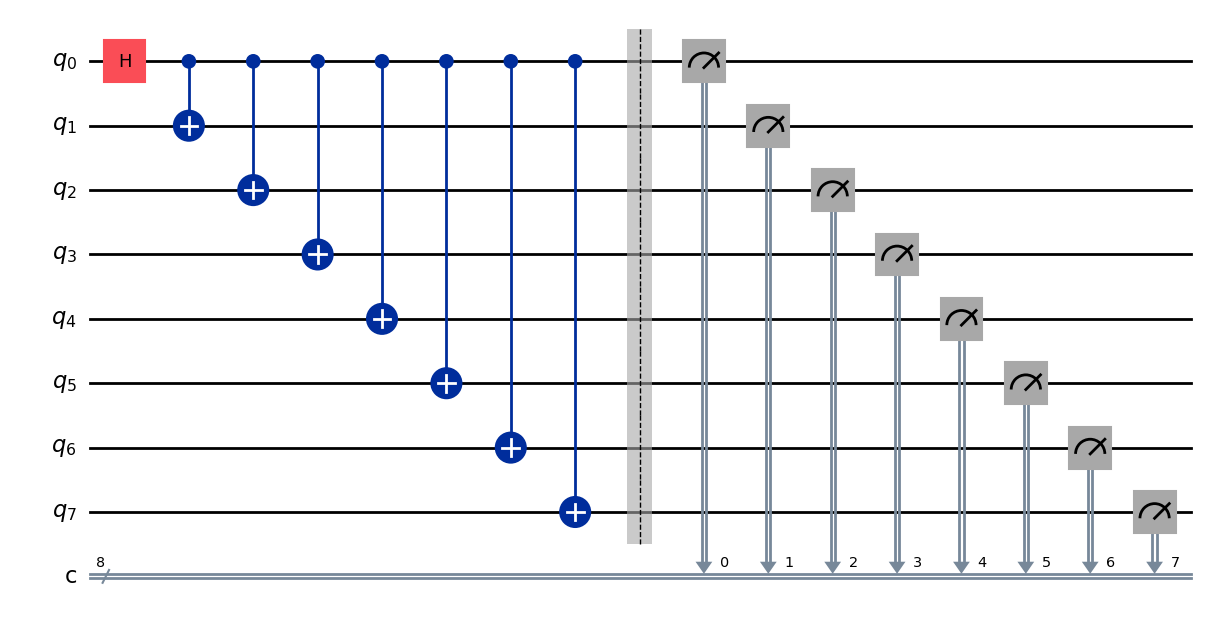

In [3]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(8,8)
qc.h(0)

for i in range(7):
    qc.cx(0,i+1)

qc.barrier()

for i in range(8):
    qc.measure(i, i)

qc.draw("mpl")

上記回路のDepthは、9 です。

In [4]:
qc.depth()

9

{'11111111': 517, '00000000': 507}


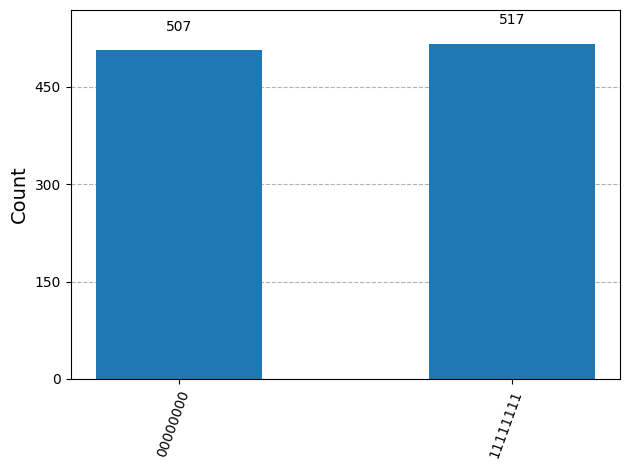

In [5]:
from qiskit_aer import AerSimulator
# シミュレーターで実験
backend = AerSimulator()
job = backend.run(qc, shots=1024)
result = job.result()

#  測定された回数を表示
counts = result.get_counts(qc)
print(counts)

from qiskit.visualization import plot_histogram
## ヒストグラムで測定された確率をプロット
plot_histogram( counts )

実機のバックエンドデバイスで実行してみましょう。

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

your_api_key = "deleteThisAndPasteYourAPIKeyHere"
your_crn = "deleteThisAndPasteYourCRNHere"

service = QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token=your_api_key,
    instance=your_crn,
    set_as_default=True,
    overwrite=True,
)

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService() 
service.backends()

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>]

In [7]:
# 使うデバイスを指定します
backend = service.backend('ibm_brisbane')

バックエンドのカップリングマップを見てみましょう。

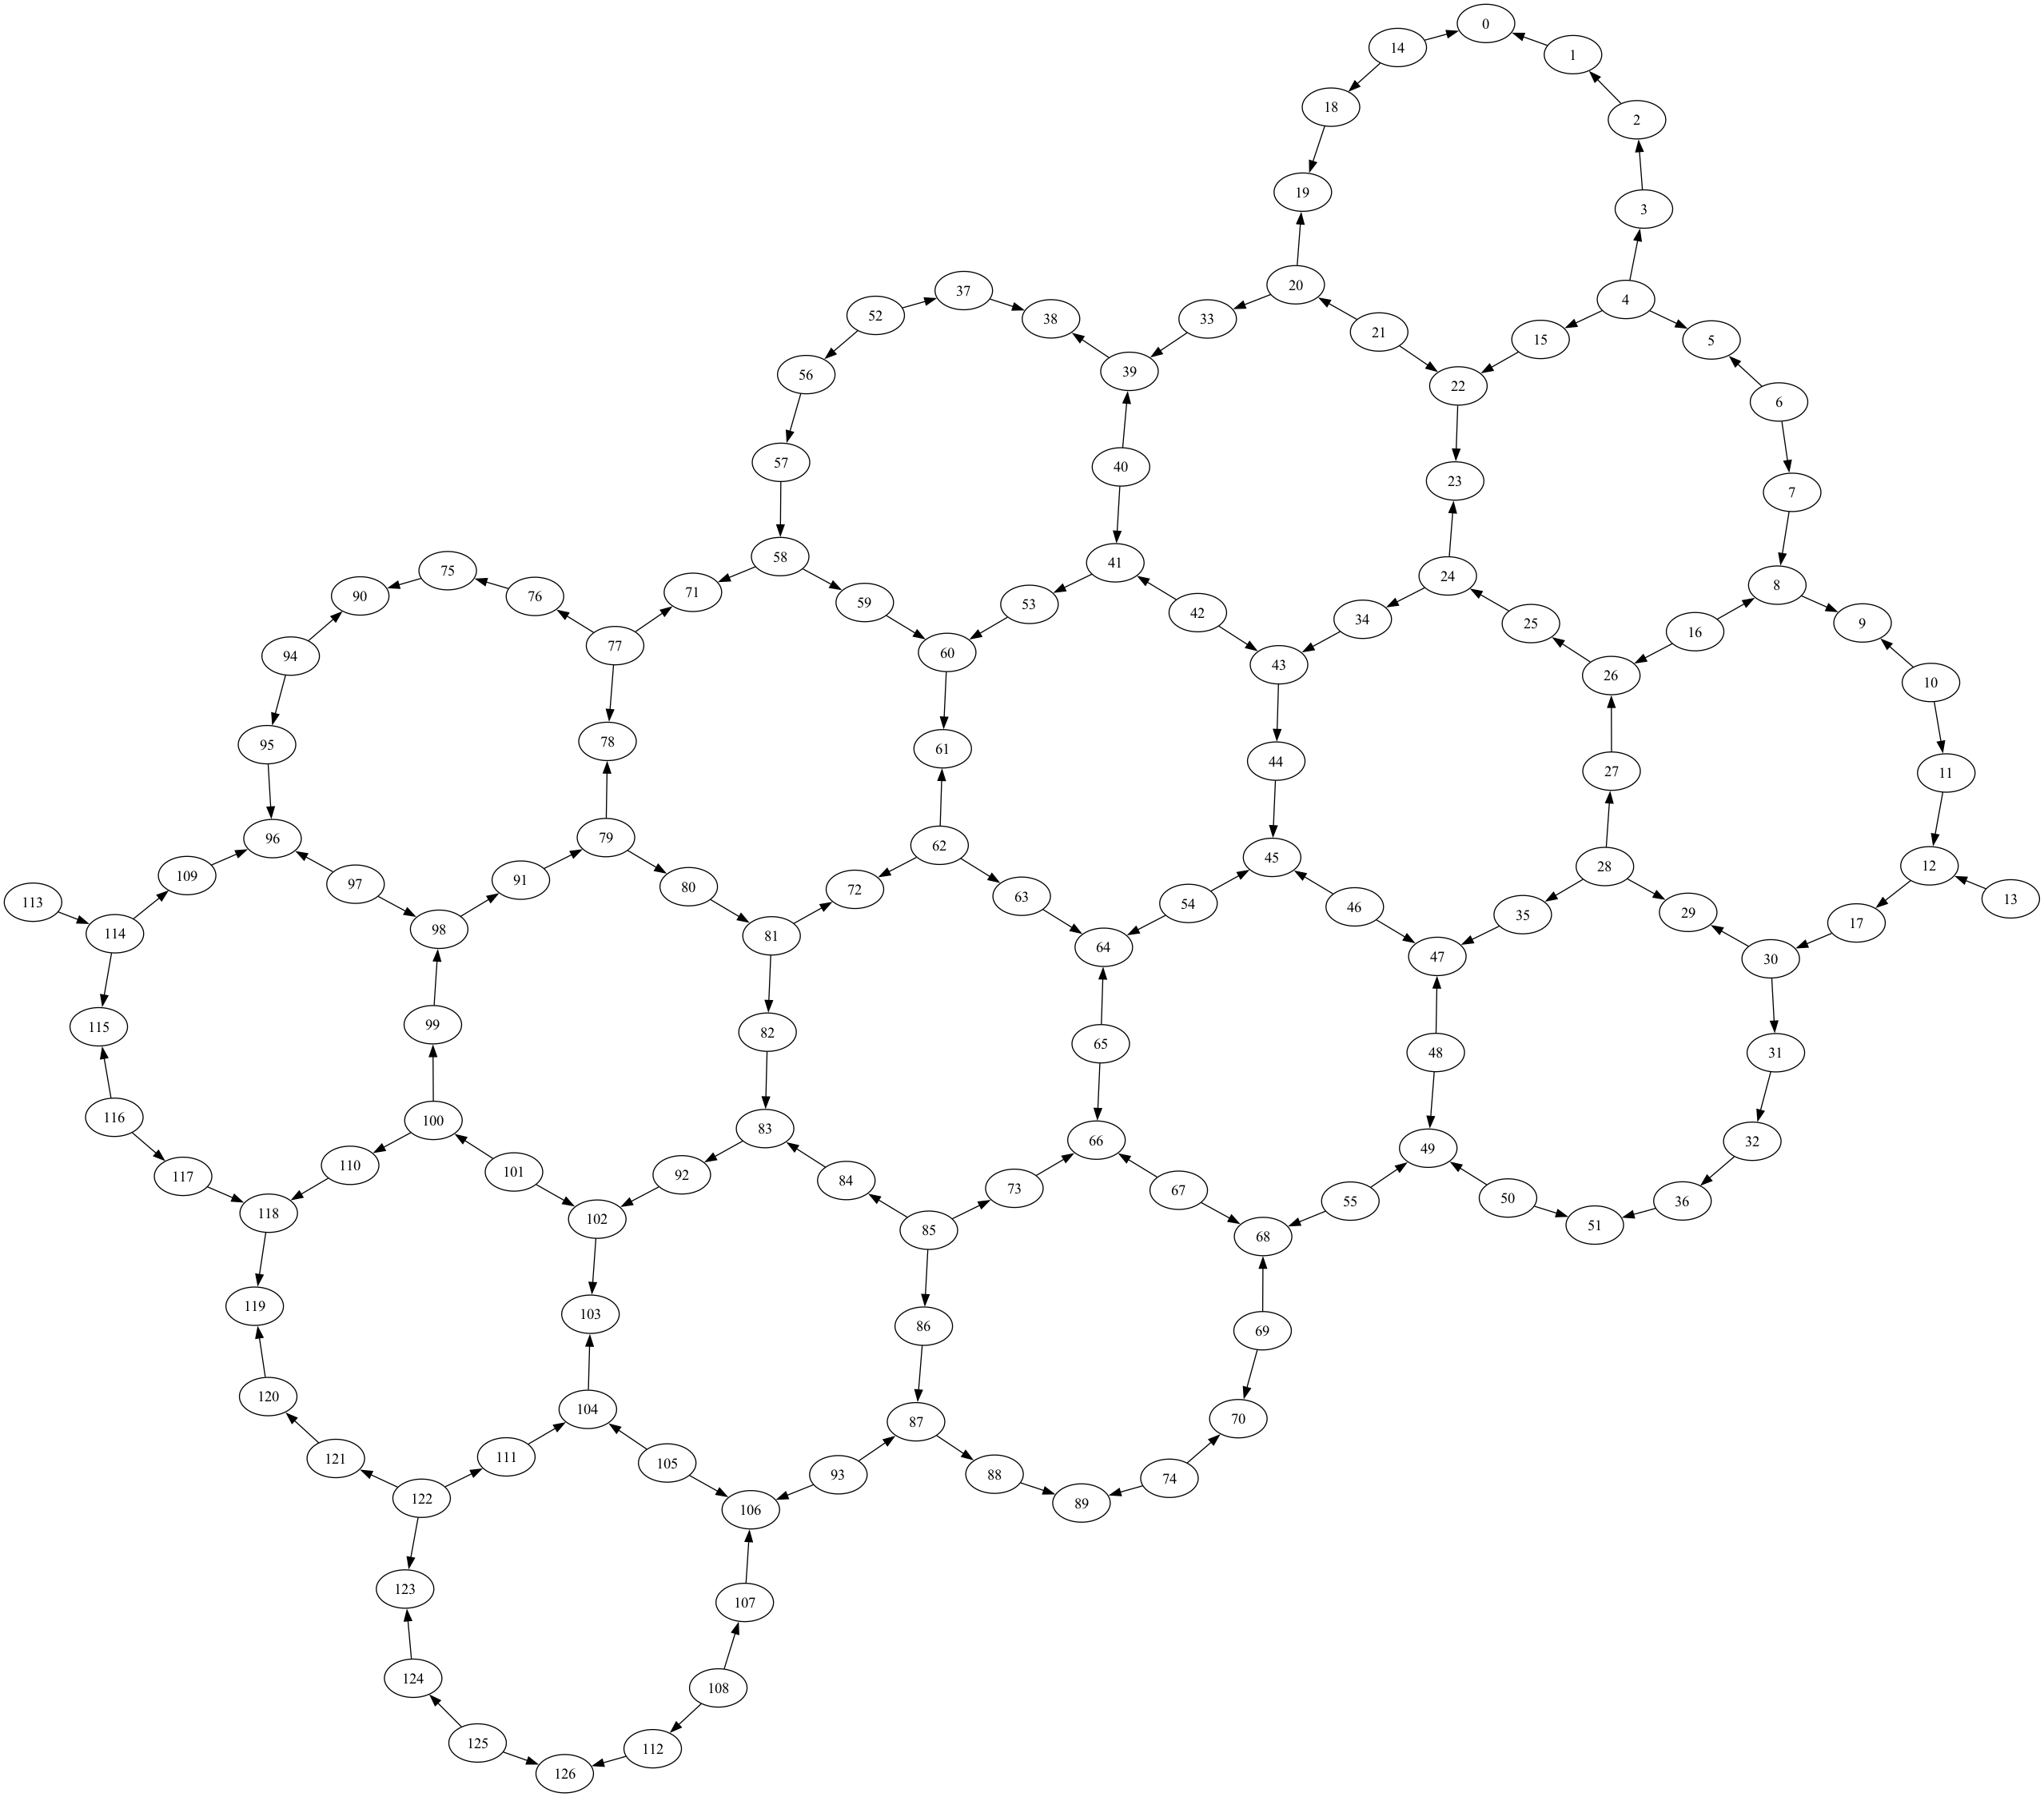

In [8]:
# 実機の量子ビットの接続を取得、描画
coupling_map=backend.coupling_map
coupling_map.draw()

また、バックエンドで実行可能な基本ゲートを見てみます。

In [9]:
backend.basis_gates

['ecr', 'id', 'rz', 'sx', 'x']

このカップリングマップや基本ゲートは、量子プロセッサーによって異なります。参照：https://quantum.ibm.com/services/resources　

実機で実行する前に、指定したバックエンドで実行可能なゲートと回路にトランスパイルする必要があります。

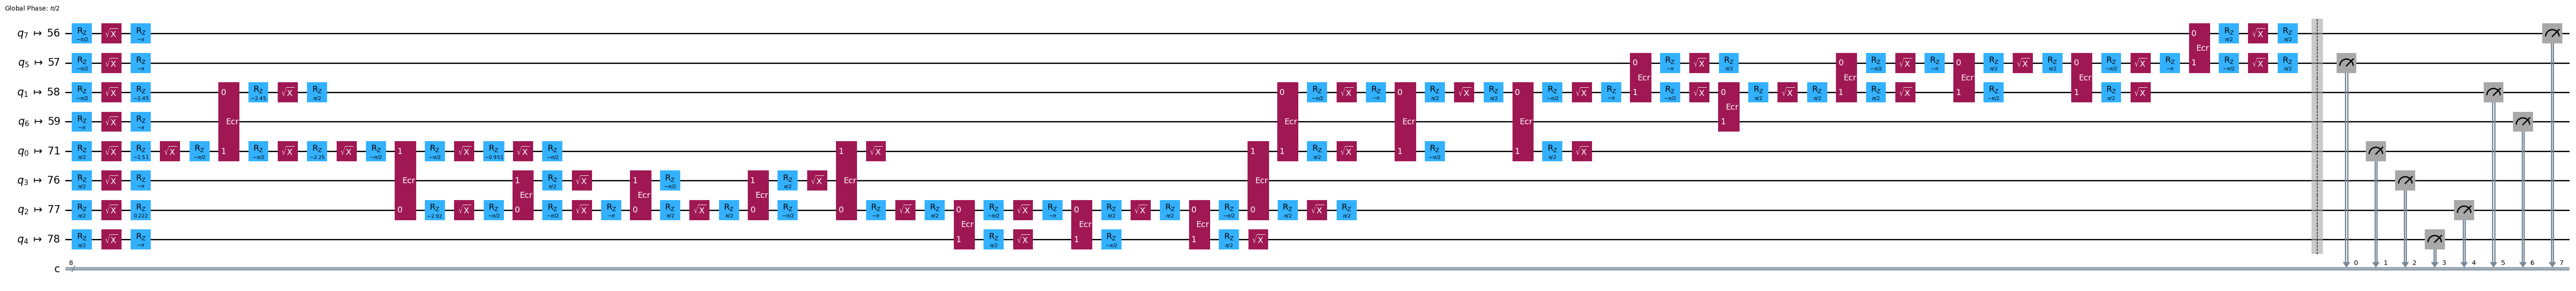

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# 実機のバックエンドでの実行に最適な回路に変換します
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_transpiled = pm.run(qc)

qc_transpiled.draw("mpl", idle_wires=False, fold=-1)

トランスパイルされた回路の深さと2量子ビットレイヤーの深さを確認してみましょう。

In [11]:
print('Depth:', qc_transpiled.depth())
print('Two-qubit Depth:', qc_transpiled.depth(filter_function=lambda x: x.operation.num_qubits==2))

Depth: 76
Two-qubit Depth: 19


実行してみましょう。

In [12]:
from qiskit_ibm_runtime import Sampler
sampler = Sampler(mode=backend)
shots = 40000
job = sampler.run([qc_transpiled], shots = shots)
print("job id:", job.job_id())

job id: d3btakedacis73dabudg


In [13]:
job = service.job(job.job_id()) 
#job = service.job("d33q9n50qhlc73cqqg1g") 
job.status() # ジョブの実行状態を確認します

'RUNNING'

この大きさの回路であれば実行時間は10秒程度ですが、オープンユーザー向けの量子コンピューターは、世界中の人から活用されているため、実行順が回ってくるまで待ち時間のかかる場合が多いです。演習時間中に実行が終わらない場合がほとんどですので、のちほどjob_idを使って、ジョブを呼び出し、結果を確認してください。

In [16]:
# 待ち時間が長い時に後から結果を確認する場合
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
job = service.job('d3btakedacis73dabudg') # 例です。上に出力された自分のjob_idを入れて実行してください。
job.status()

'DONE'

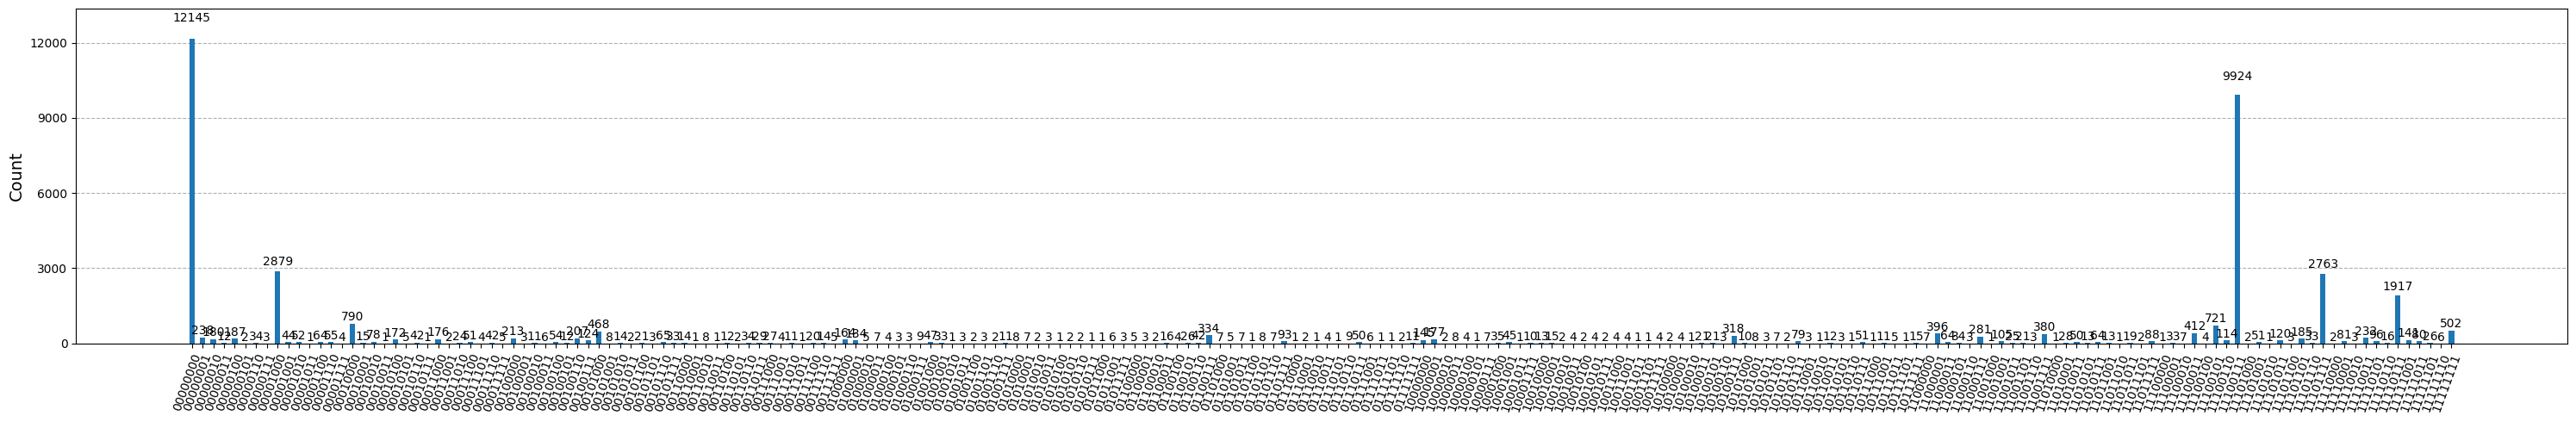

In [17]:
### 'DONE'になってから実行します ###
from qiskit.visualization import plot_histogram
result = job.result()
plot_histogram(result[0].data.c.get_counts(), figsize=(30, 5))

次は18量子ビットに増やしてみます。

## 2. 回路深さの探求

様々なGHZ回路の回路Depthを確認してみましょう。

まずは、何のスキームも工夫もなしに作った、18量子ビットのGHZ状態です。

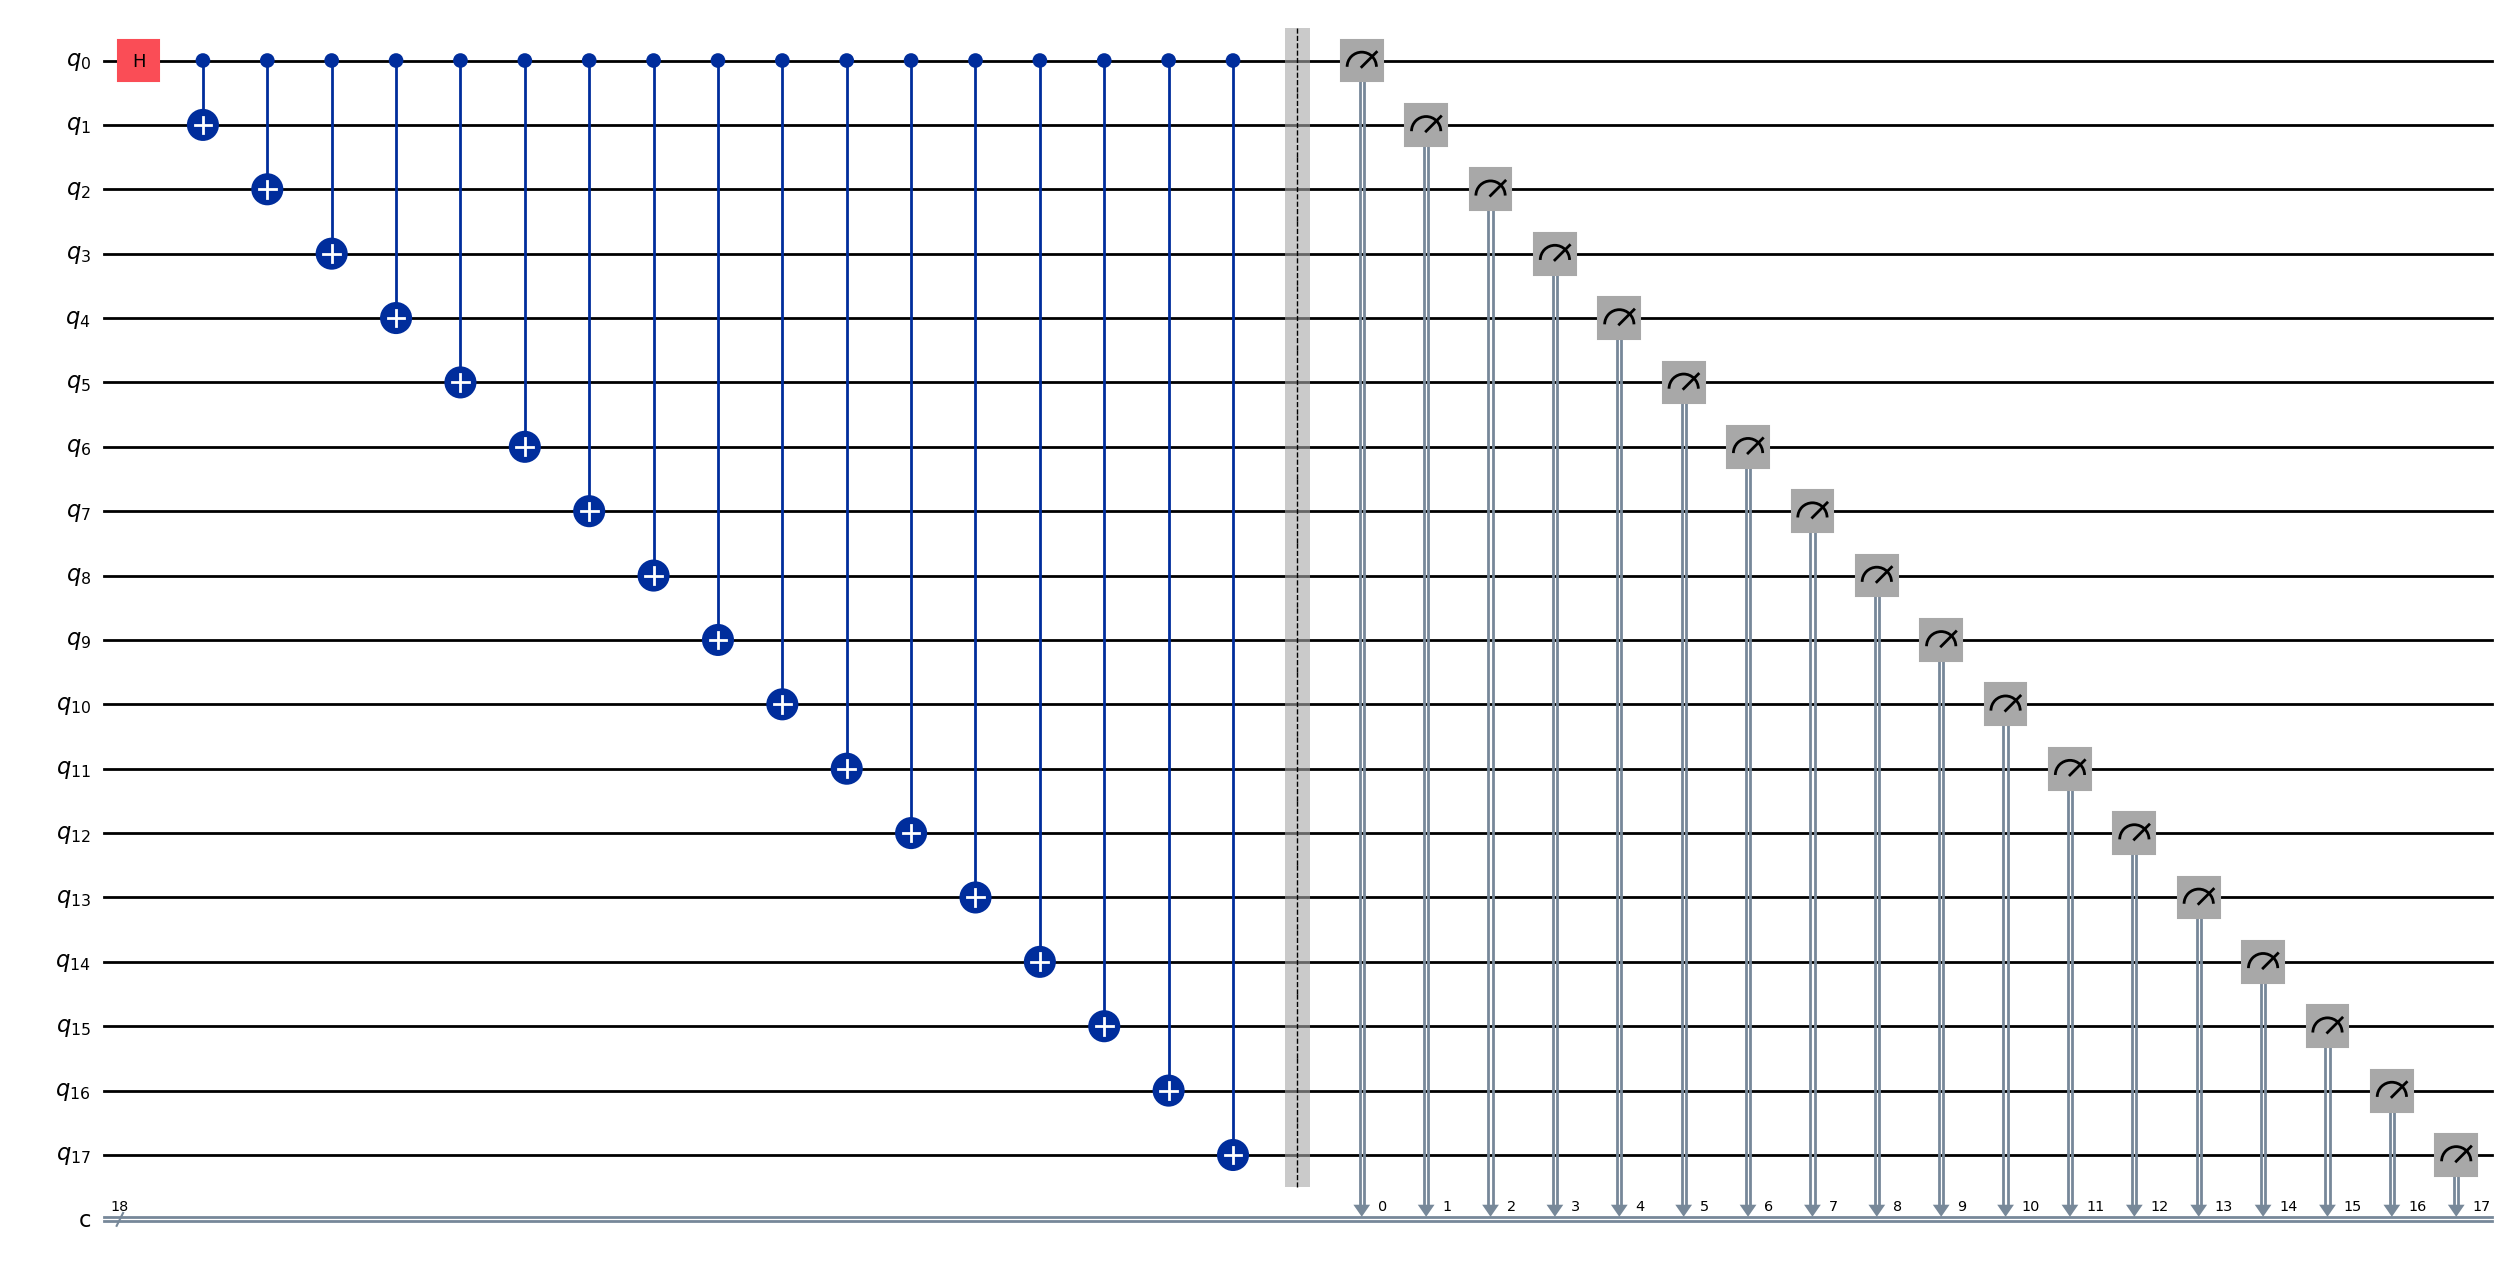

In [12]:
n = 18
qc = QuantumCircuit(n,n)
qc.h(0)

for i in range(n-1):
    qc.cx(0,i+1)

qc.barrier()

# 測定
for i in range(n):
    qc.measure(i, i)

qc.draw("mpl", fold=-1)

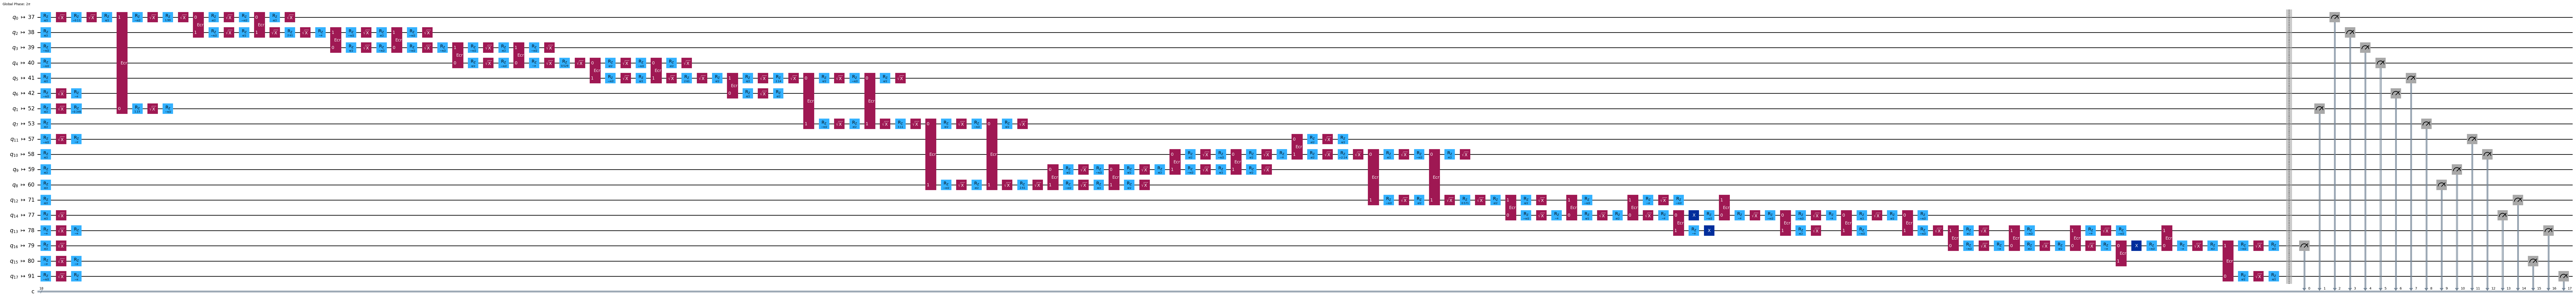

In [13]:
# 実機のバックエンドでの実行に最適な回路に変換します
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_transpiled = pm.run(qc)

qc_transpiled.draw("mpl", idle_wires=False, fold=-1)

In [14]:
print('Depth:', qc_transpiled.depth())
print('Two-qubit Depth:', qc_transpiled.depth(filter_function=lambda x: x.operation.num_qubits==2))

Depth: 148
Two-qubit Depth: 35


次に、隣接する量子ビット同士を接続するCNOTゲートを配置して作れると、回路深さは約半分に減少します。

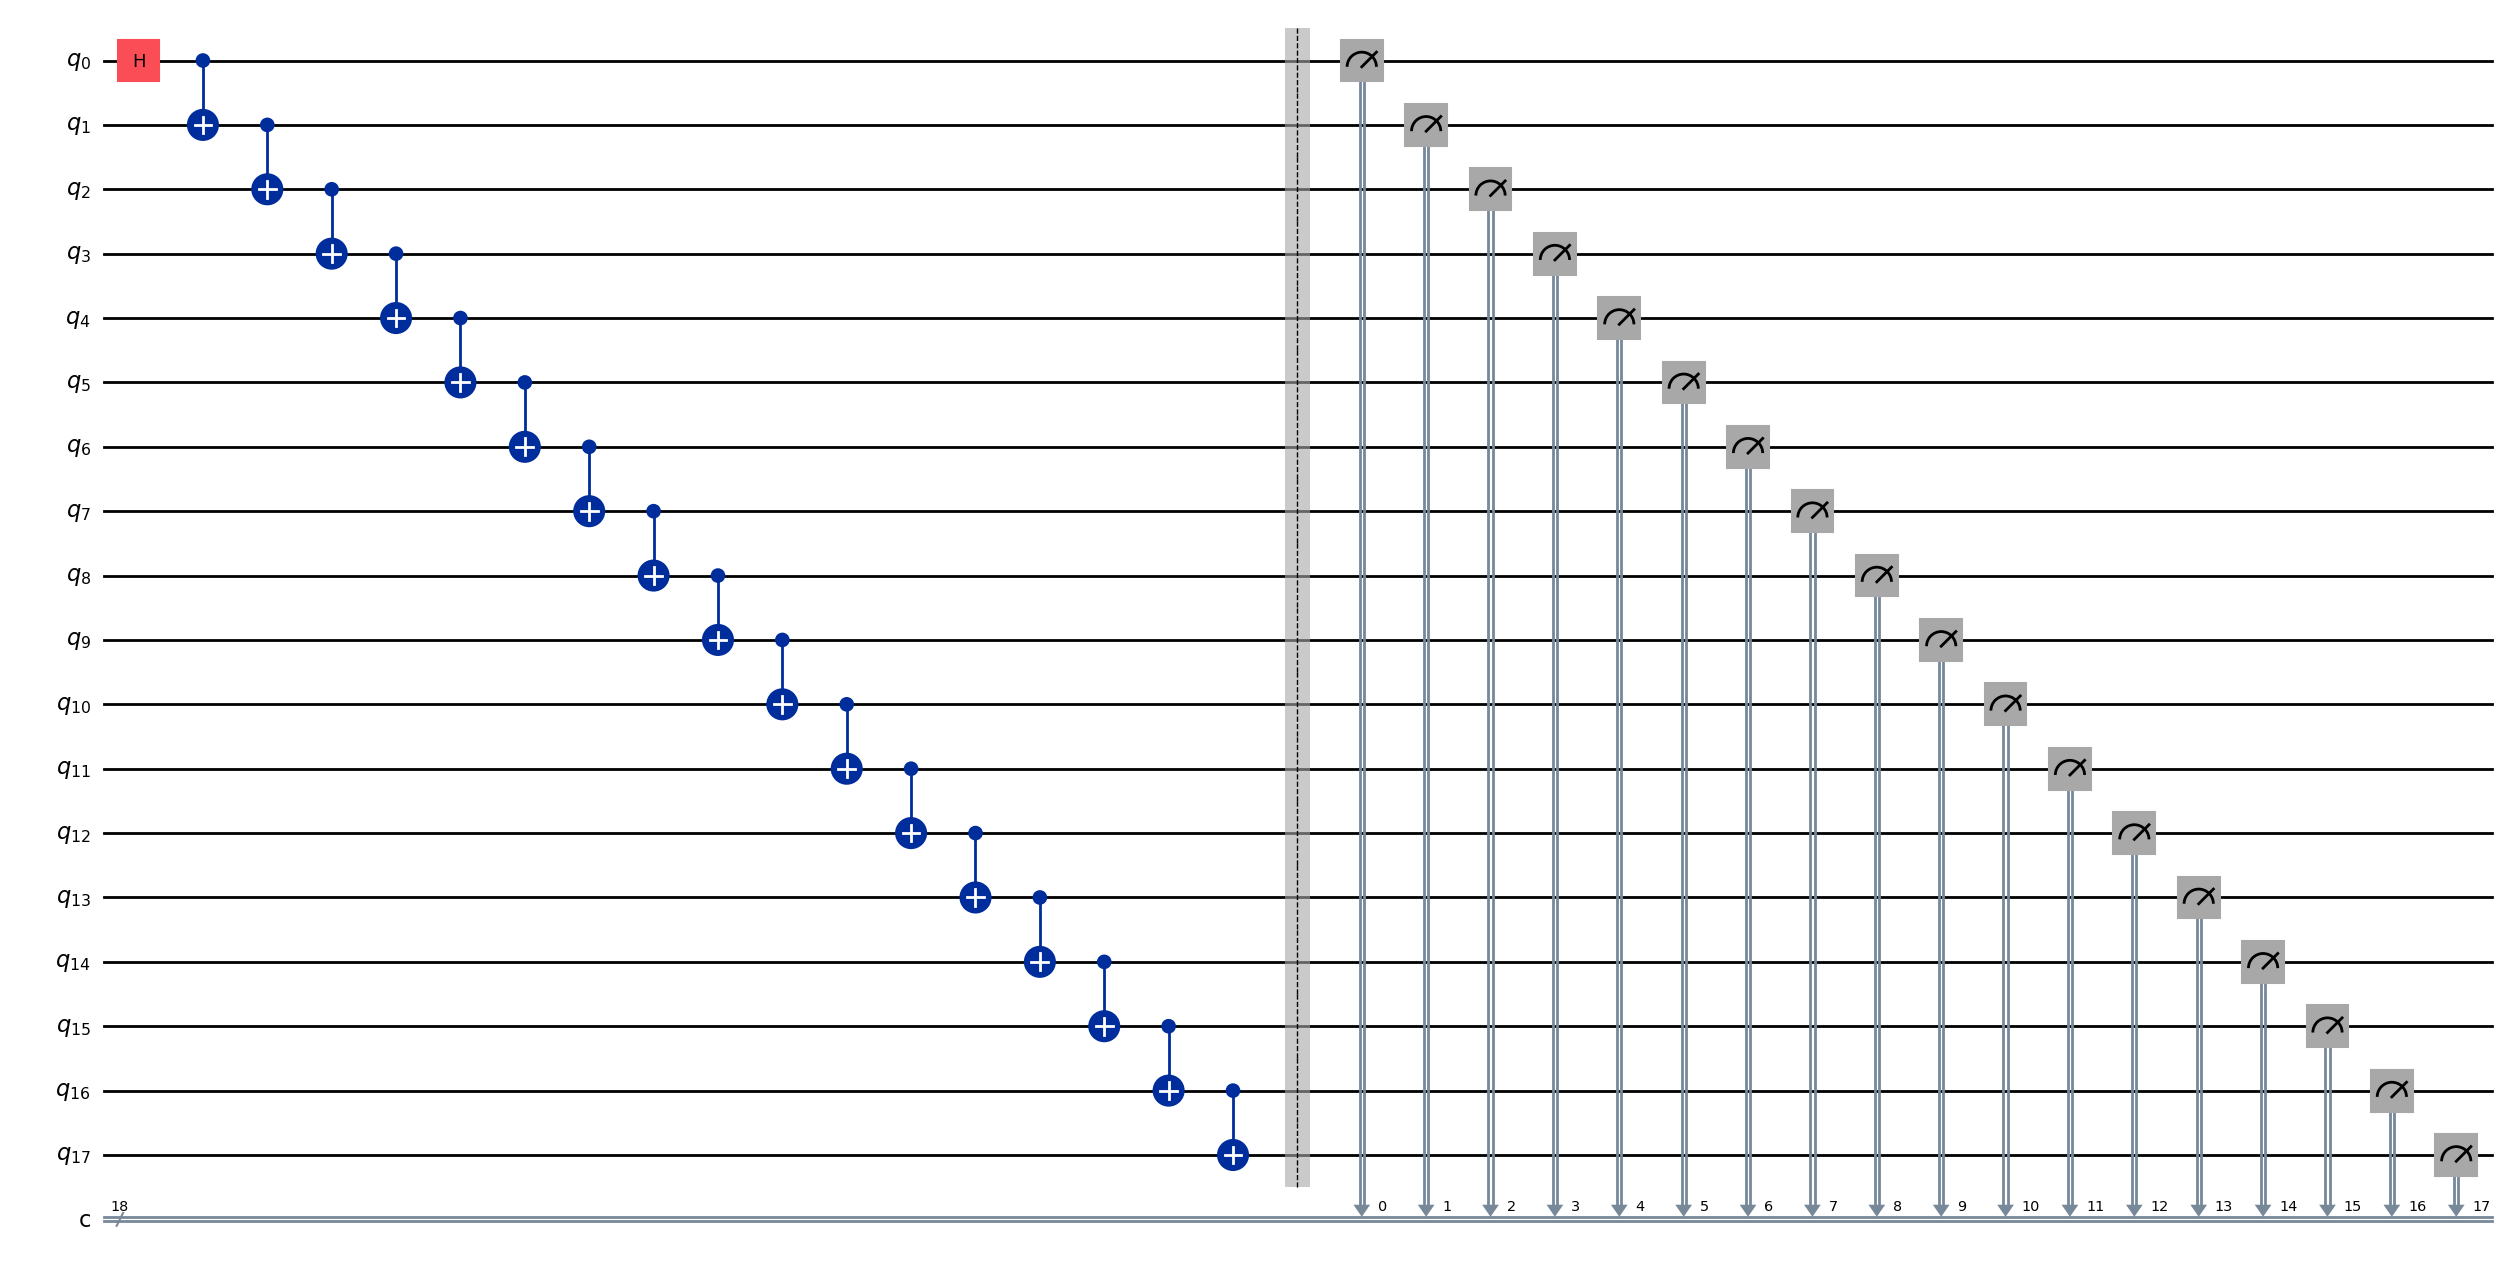

In [15]:
qc = QuantumCircuit(n,n)
qc.h(0)
for i in range(n-1):
    qc.cx(i,i+1)

qc.barrier()

# 測定
for i in range(n):
    qc.measure(i, i)

qc.draw("mpl", fold=-1)

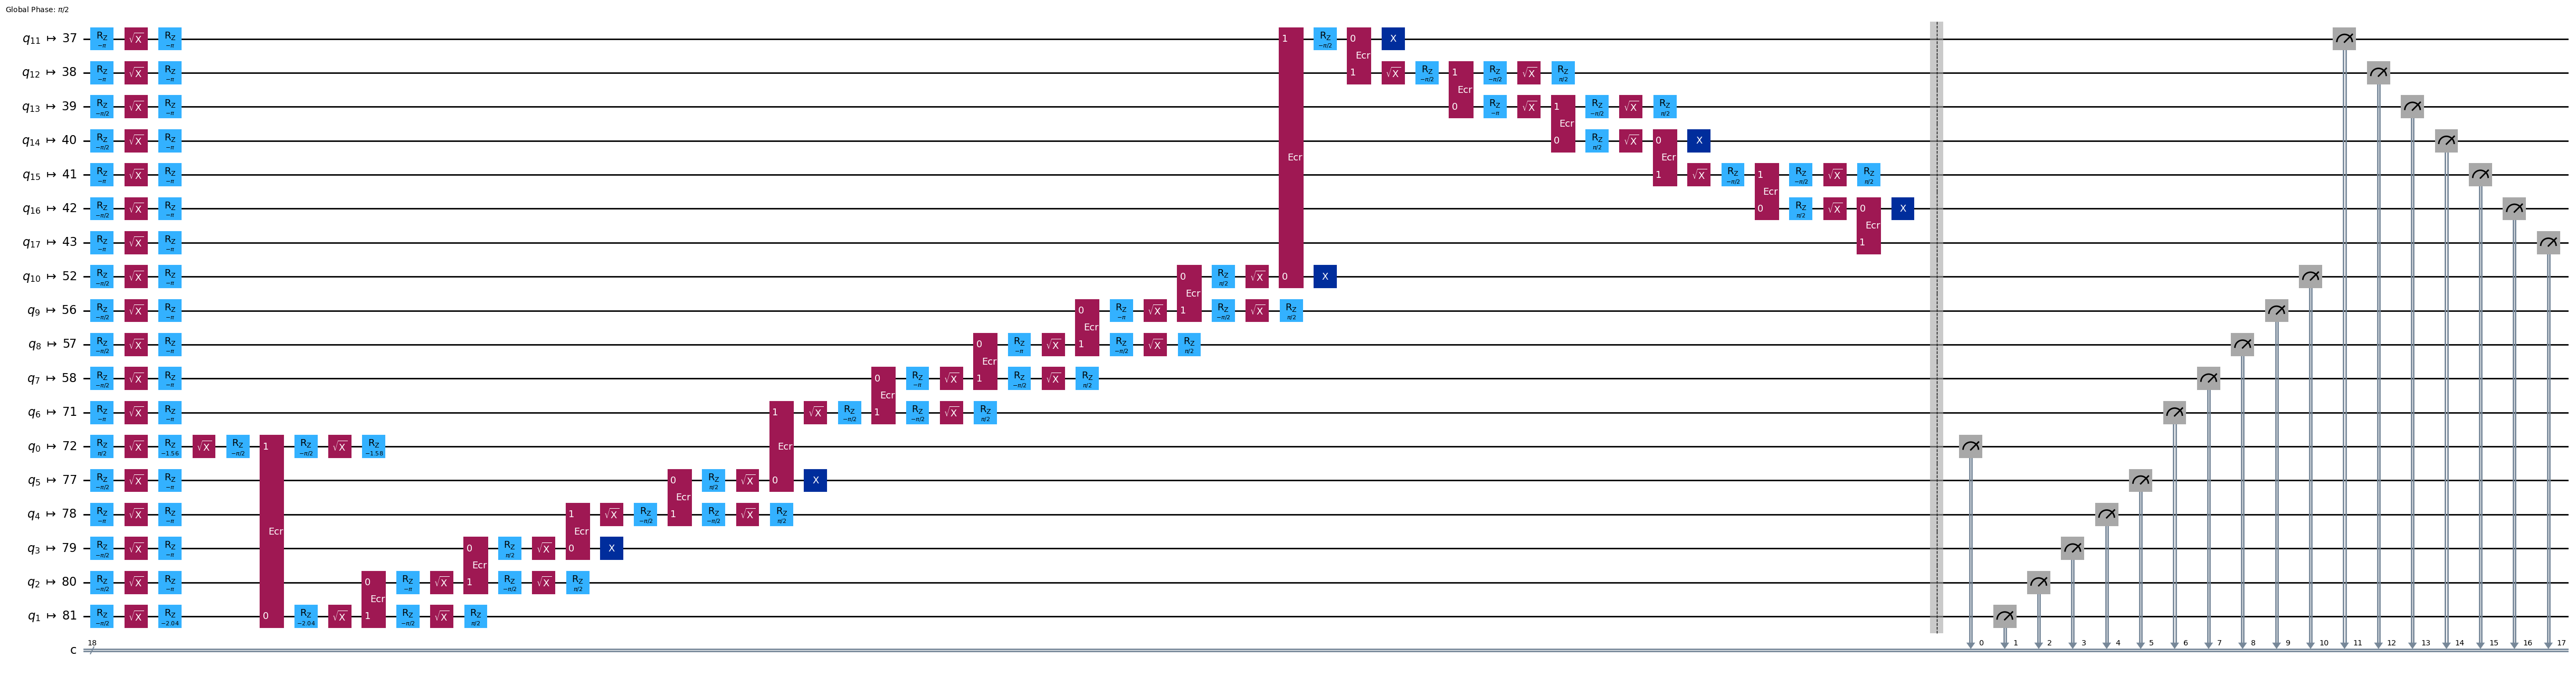

In [16]:
# 実機のバックエンドでの実行に最適な回路に変換します
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_transpiled = pm.run(qc)

qc_transpiled.draw("mpl", idle_wires=False, fold=-1)

In [17]:
print('Depth:', qc_transpiled.depth())
print('Two-qubit Depth:', qc_transpiled.depth(filter_function=lambda x: x.operation.num_qubits==2))

Depth: 55
Two-qubit Depth: 17


中央から始める回路を使うとさらに回路深さを減らすことができます。

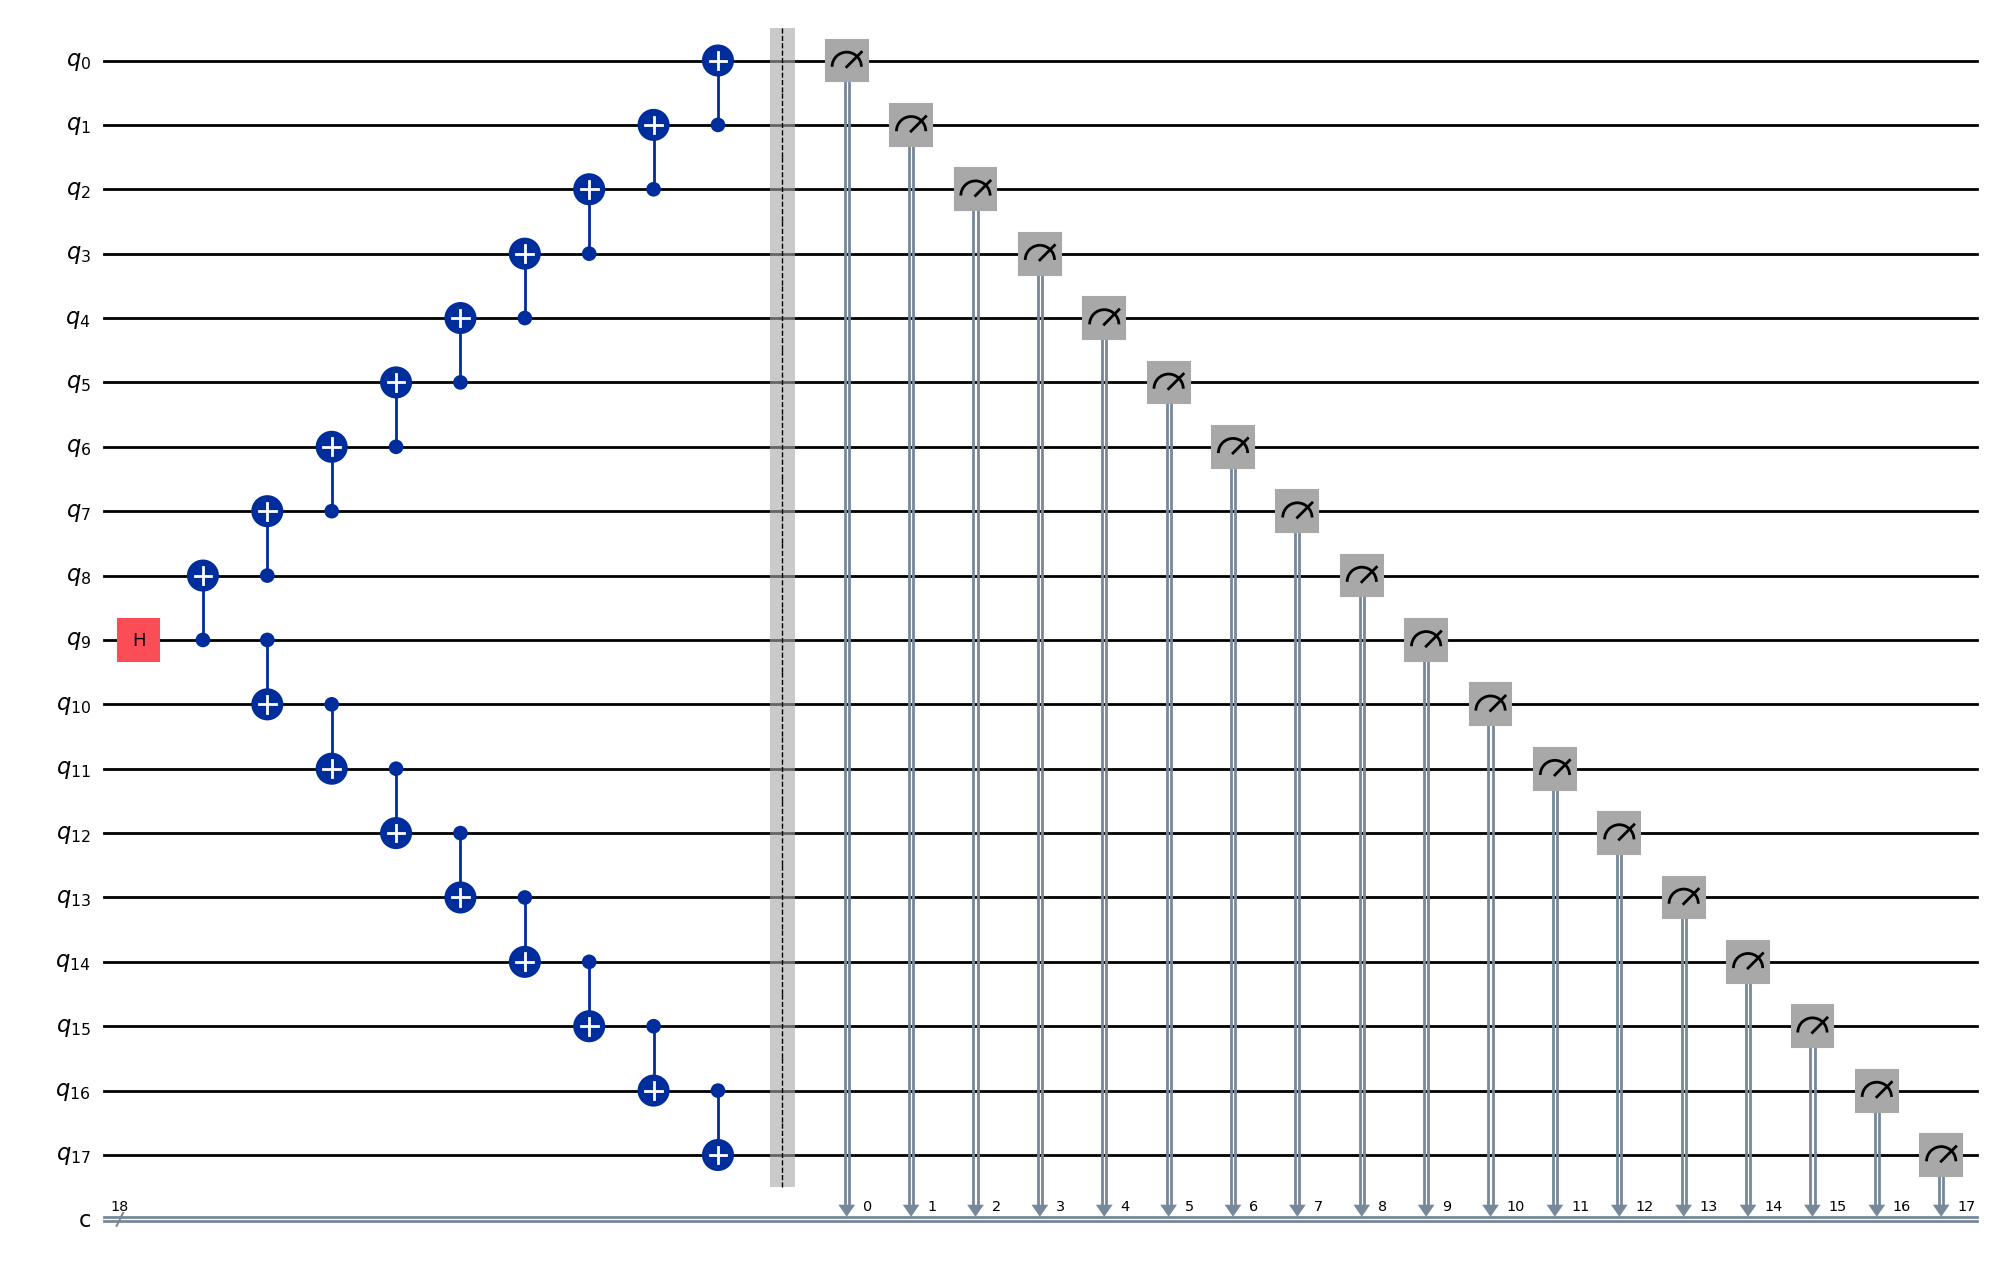

In [18]:
qc = QuantumCircuit(n,n)

qc.h(n//2)
for i in range(n//2, 0, -1):
    qc.cx(i, i-1)
    
for i in range(n//2, n-1, +1):
    qc.cx(i, i+1)

qc.barrier()

# 測定
for i in range(n):
    qc.measure(i, i)

qc.draw("mpl", fold=-1)

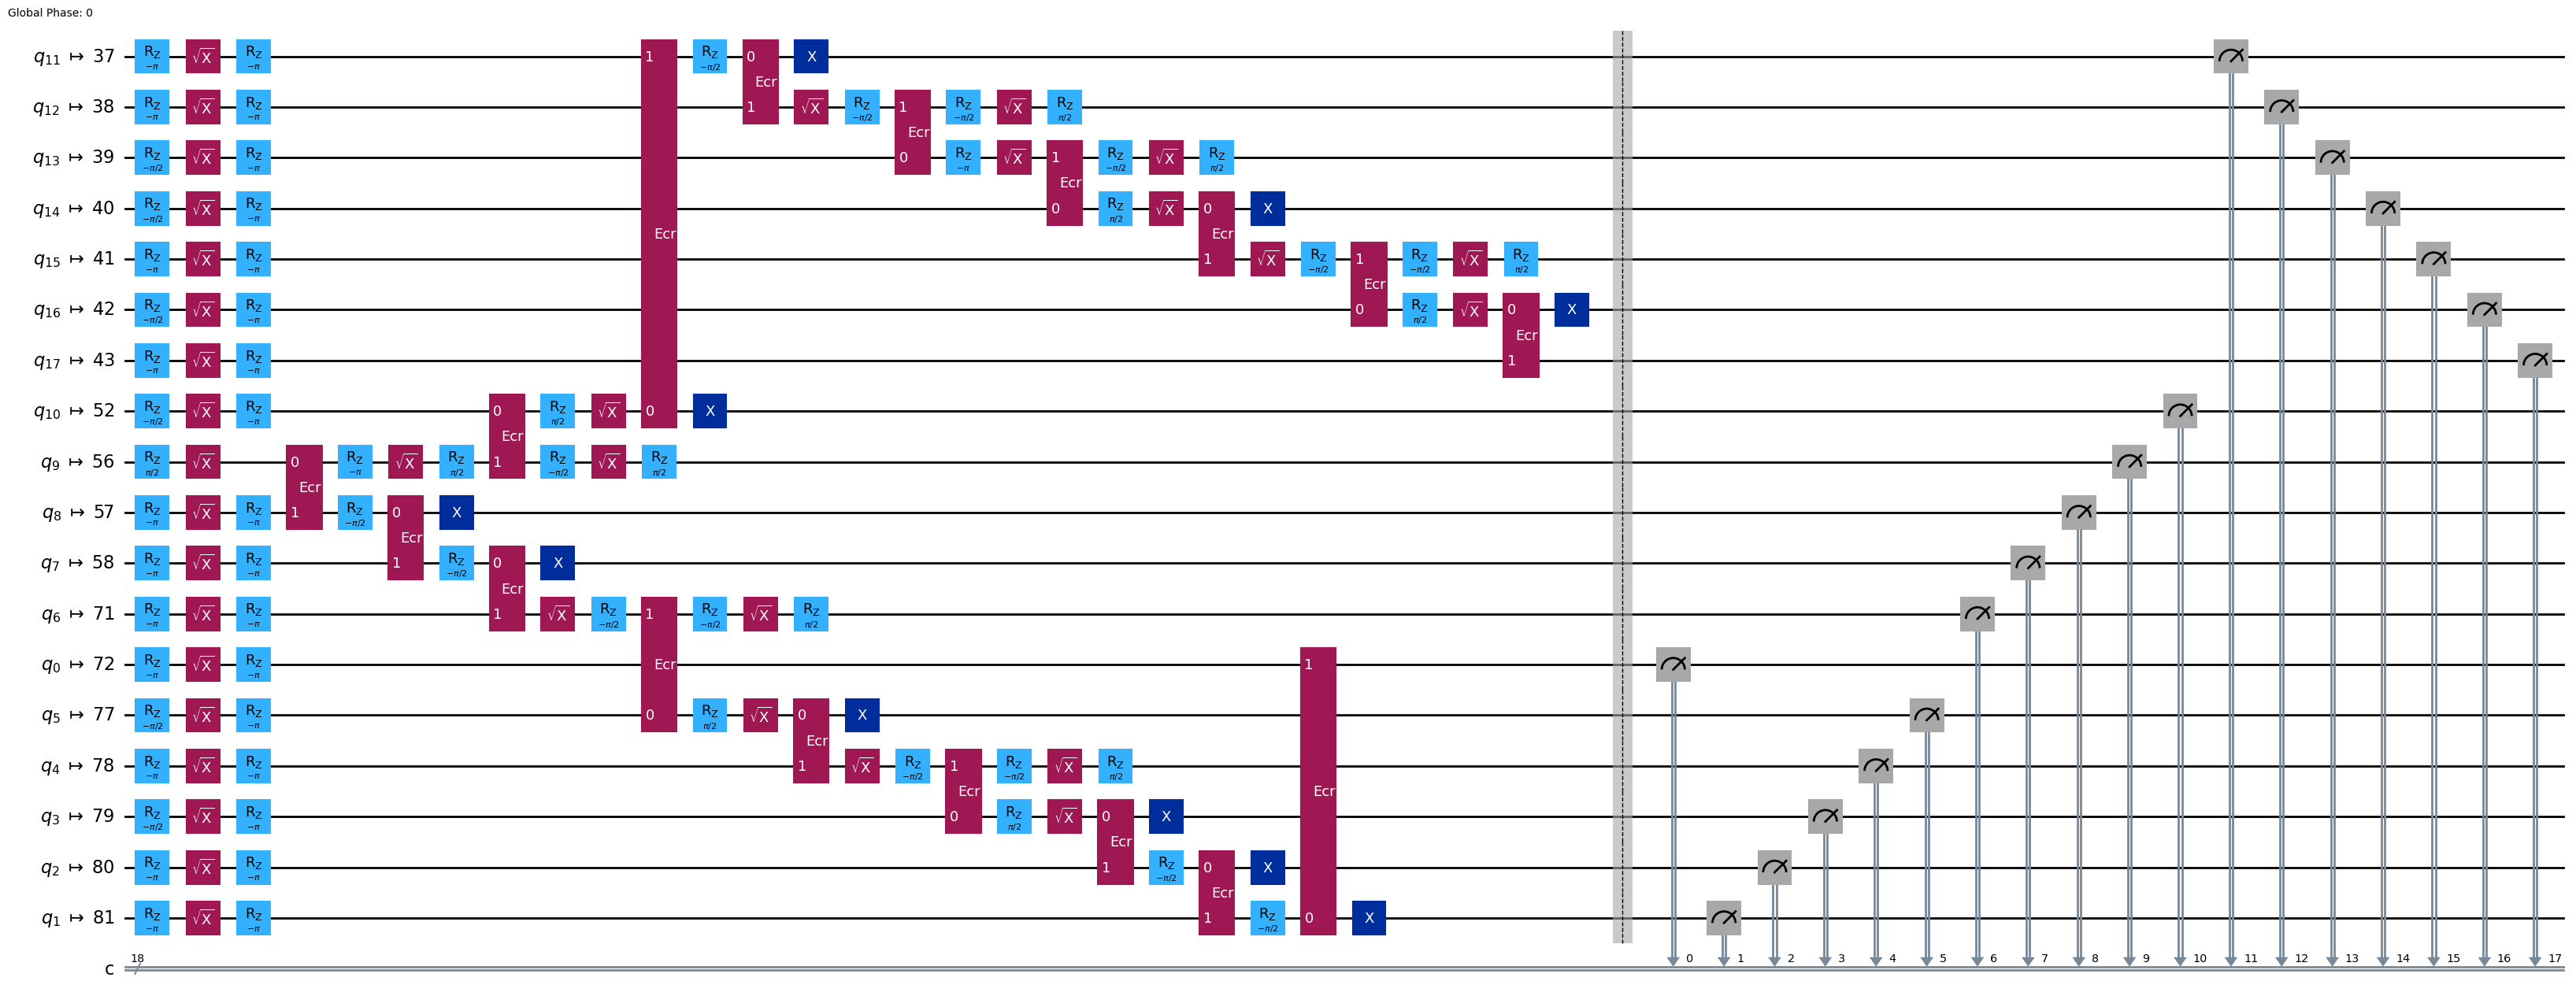

In [19]:
# 実機のバックエンドでの実行に最適な回路に変換します
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_transpiled = pm.run(qc)

qc_transpiled.draw("mpl", idle_wires=False, fold=-1)

In [20]:
print('Depth:', qc_transpiled.depth())
print('Two-qubit Depth:', qc_transpiled.depth(filter_function=lambda x: x.operation.num_qubits==2))

Depth: 30
Two-qubit Depth: 9


In [21]:
from qiskit_ibm_runtime import Sampler
sampler = Sampler(mode=backend)
shots = 40000
job = sampler.run([qc_transpiled], shots = shots)
print("job id:", job.job_id())

job id: d3btd2nc8jls73bvm95g


In [22]:
job = service.job(job.job_id()) 
#job = service.job("d33q9n50qhlc73cqqg1g") 
job.status() # ジョブの実行状態を確認します

'DONE'

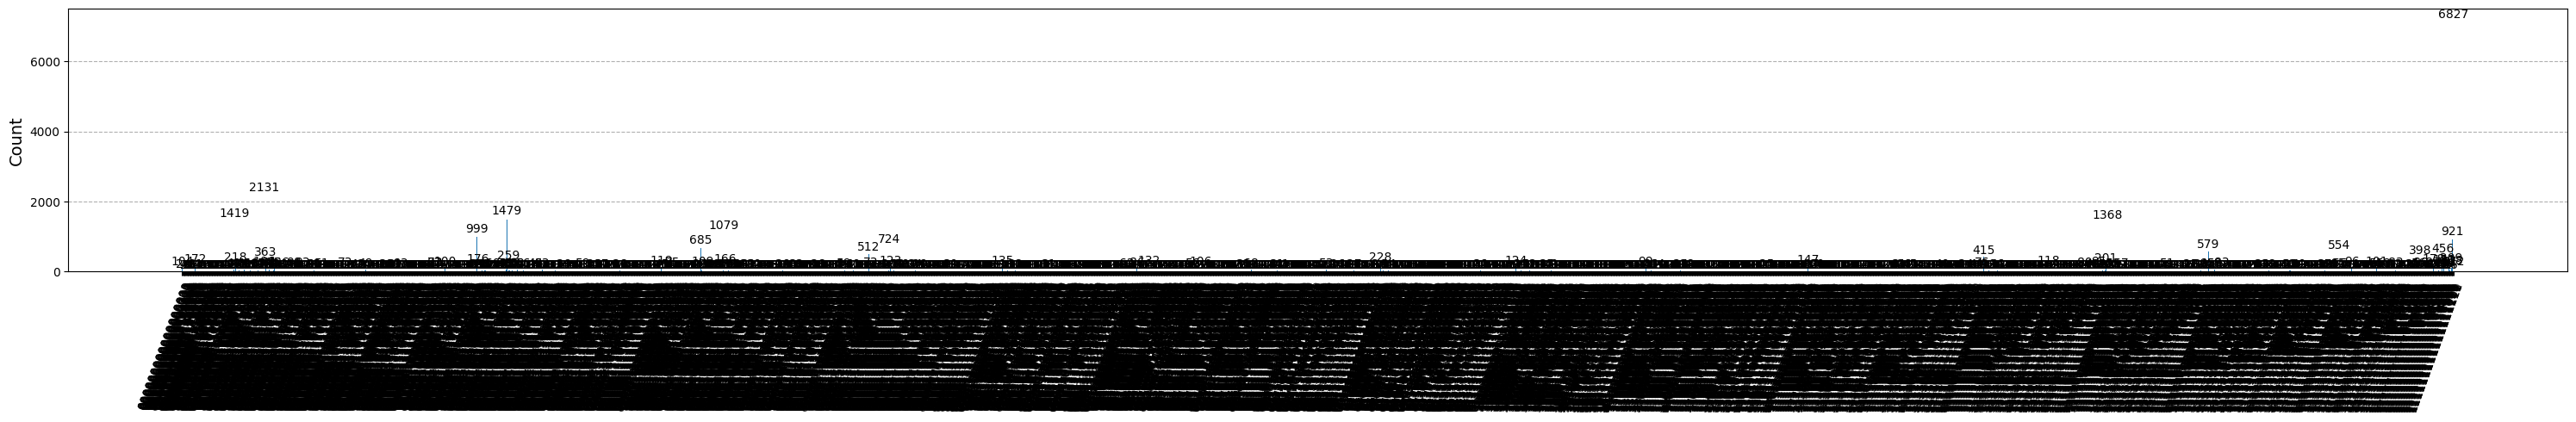

In [23]:
### 'DONE'になってから実行します ###
#from qiskit.visualization import plot_histogram
result = job.result()
plot_histogram(result[0].data.c.get_counts(), figsize=(30, 5))

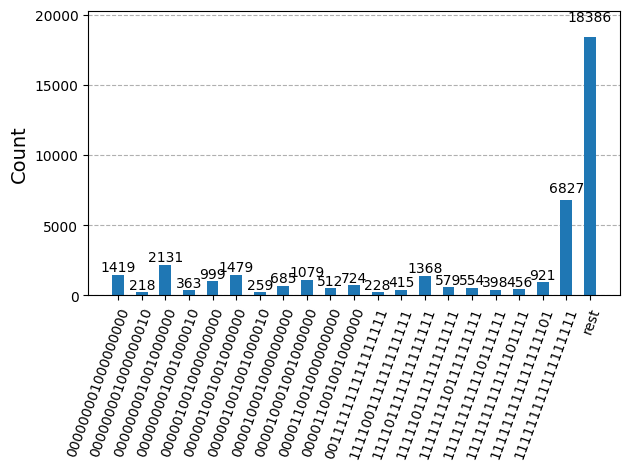

In [24]:
plot_histogram(result[0].data.c.get_counts(), number_to_keep=20)

この後には、GHZ状態を作るための3つのアイディアを18量子ビットの回路を用いて紹介します。

## 3. 精度の良い量子ビットを選択する

### 2量子ビットゲートエラーをもとに最良の量子ビットチェーンを探す

最初にバックエンドを指定します。
また、今回は、Eagleデバイスを使うため、2量子ビットゲートを`ecr`ゲートにセットします。

In [25]:
twoq_gate = "ecr"
print(f"Device {backend.name} Loaded with {backend.num_qubits} qubits")
print(f"Two Qubit Gate: {twoq_gate}")

Device ibm_brisbane Loaded with 127 qubits
Two Qubit Gate: ecr


まずは、バックエンドの接続特性をグラフにします。この結果、グラフのアルゴリズムツールが使えるようになります。

In [26]:
coupling_map = backend.target.build_coupling_map(twoq_gate)
G = coupling_map.graph

選んだバックエンドの2量子ビットゲートエラーのデータに基づいて、最適な「量子ビットチェーン」を見つけるために、いくつか関数を定義します。

In [27]:
import numpy as np
def to_edges(path): #ノード(量子ビット)のパスからエッジ(接続)リストを作成
    edges = []
    prev_node = None
    for node in path:
        if prev_node is not None:
            if G.has_edge(prev_node, node):
                edges.append((prev_node, node))
            else:
                edges.append((node, prev_node))
        prev_node = node
    return edges


def path_fidelity(path, correct_by_duration: bool = True, readout_scale: float = None):
    """ パス上の2量子ビットゲートの合計忠実度の推定値を計算します。
    `correct_by_duration` がtrueの場合、各ゲートの忠実度はscale = max_duration / duration、
    つまり gate_fidelity^scale だけ悪化します。
    `readout_scale` > 0 が指定されている場合、パス上の各量子ビットのreadout_fidelity^readout_scaleが
    合計忠実度に掛けられます。
    パスはノードインデックス形式で指定されます (例: [0, 1, 2])。
    外部関数`to_edges`を使用してエッジリストを取得します (例: [(0, 1), (1, 2)])。"""
    path_edges = to_edges(path)
    max_duration = max(backend.target[twoq_gate][qs].duration for qs in path_edges)

    def gate_fidelity(qpair):
        duration = backend.target[twoq_gate][qpair].duration
        scale = max_duration / duration if correct_by_duration else 1.0
        # 1.25 = (d+1)/d with d = 4
        return max(0.25, 1 - (1.25 * backend.target[twoq_gate][qpair].error)) ** scale

    def readout_fidelity(qubit):
        return max(0.25, 1 - backend.target["measure"][(qubit,)].error)

    total_fidelity = np.prod([gate_fidelity(qs) for qs in path_edges]) #各パスの2量子ビットゲート忠実度
    if readout_scale:
        total_fidelity *= np.prod([readout_fidelity(q) for q in path]) ** readout_scale # 読み出し忠実度をかける
    return total_fidelity


def flatten(paths, cutoff=None):  # ランタイムを大きくしすぎないためのカットオフ
    return [
        path
        for s, s_paths in paths.items()
        for t, st_paths in s_paths.items()
        for path in st_paths[:cutoff]
        if s < t
    ]

In [28]:
N = 18 # GHZ回路で使用する量子ビット数
num_qubits_in_chain = N

グラフ内の全てのノードのペア間のN個の量子ビットの単純なパスを全て求めます（参考：[all_pairs_all_simple_paths](https://www.rustworkx.org/apiref/rustworkx.all_pairs_all_simple_paths.html#rustworkx-all-pairs-all-simple-paths)）。

次に、上で作成した `path_fidelity` 関数を用いて、最大のパス忠実度を持つ最良の「量子ビットチェーン」を見つけます。


In [29]:
%%time
import rustworkx as rx
paths = rx.all_pairs_all_simple_paths(
    G.to_undirected(multigraph=False),
    min_depth=num_qubits_in_chain,
    cutoff=num_qubits_in_chain,
)
paths = flatten(paths, cutoff=25)  # 時間があれば、もっと大きなカットオフを設定可能。
if not paths:
    raise Exception(
        f"No qubit chain with length={num_qubits_in_chain} exists in {backend.name}. Try smaller num_qubits_in_chain."
    )

print(f"Selecting the best from {len(paths)} candidate paths")
from functools import partial
best_qubit_chain = max(paths, key=partial(path_fidelity, correct_by_duration=True, readout_scale=1.0))
assert len(best_qubit_chain) == num_qubits_in_chain
print(f"Predicted (best possible) process fidelity: {path_fidelity(best_qubit_chain)}")

Selecting the best from 9816 candidate paths
Predicted (best possible) process fidelity: 0.8862315598466961
CPU times: user 371 ms, sys: 11 ms, total: 382 ms
Wall time: 375 ms


In [30]:
np.array(best_qubit_chain)

array([62, 61, 60, 53, 41, 40, 39, 38, 37, 52, 56, 57, 58, 71, 77, 76, 75,
       90], dtype=uint64)

ベストな量子ビットチェーンが見つかったので、カップリング・マップ・グラフにピンクでプロットしてみます。

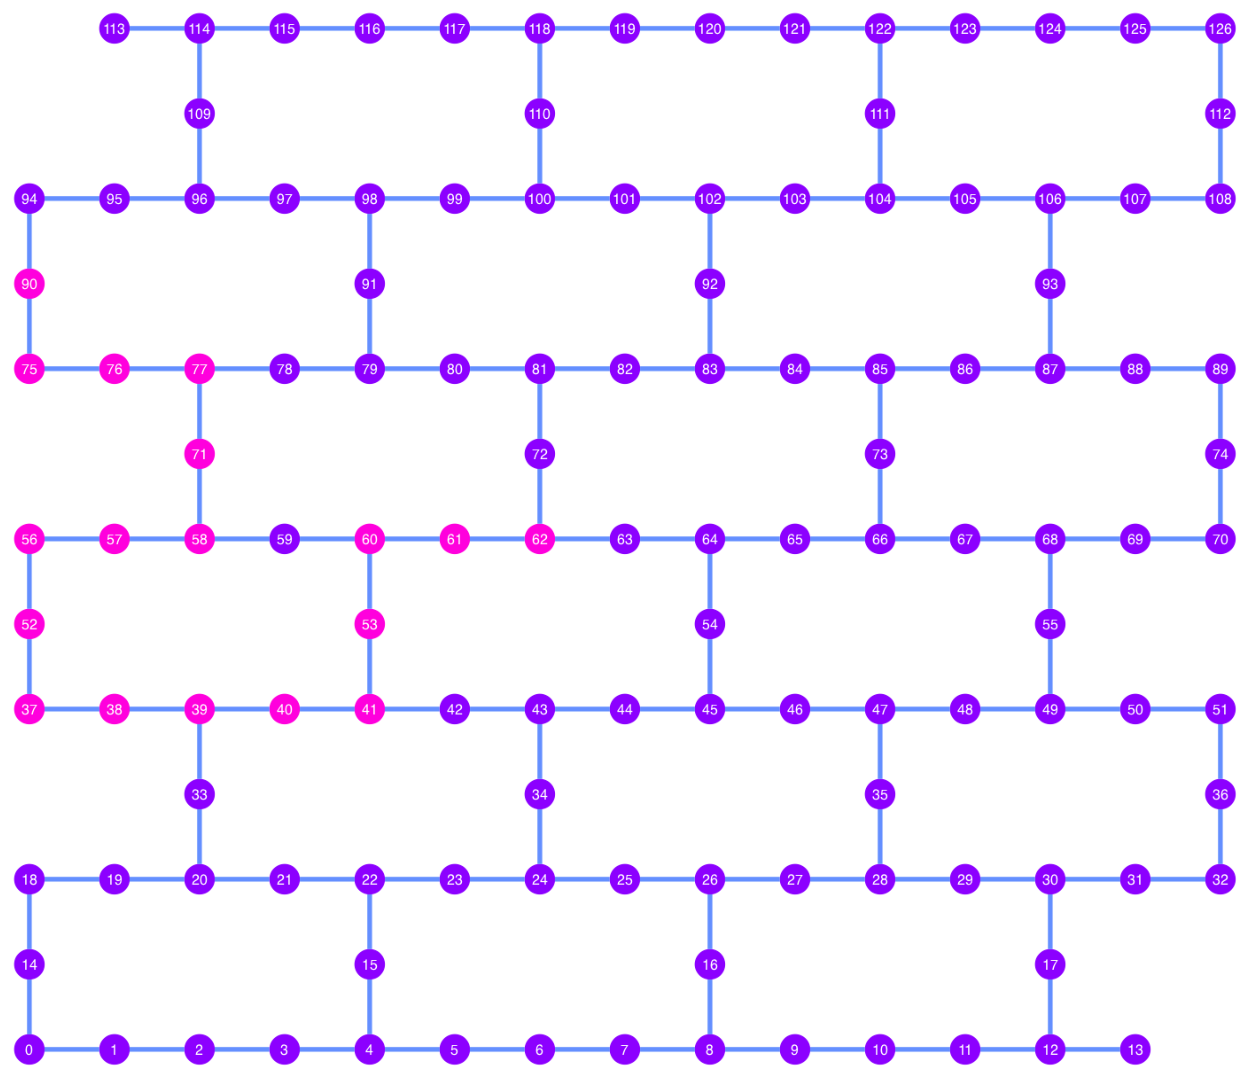

In [31]:
from qiskit.visualization import plot_gate_map

qubit_color = []
for i in range(backend.num_qubits):
    if i in best_qubit_chain:
        qubit_color.append("#ff00dd") #pink
    else:
        qubit_color.append("#8c00ff") #purple
plot_gate_map(backend, qubit_color=qubit_color)

### 最良の量子ビットチェーン上にGHZ回路を構築する

最初にHゲートを適用する量子ビットをチェーンの真ん中に選び、回路の奥行きを約半分にします。

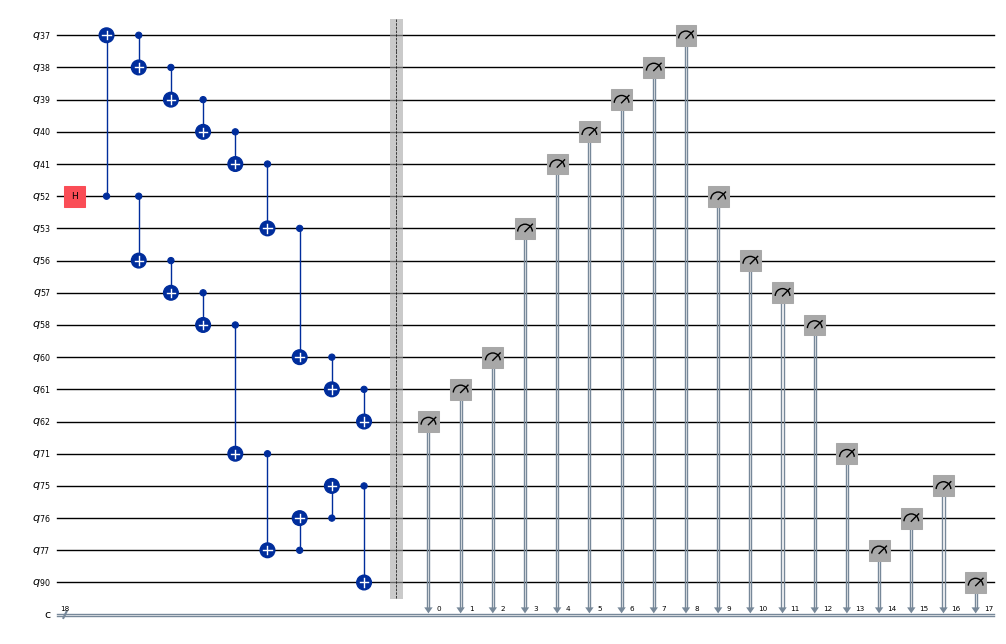

In [32]:
ghz1 = QuantumCircuit(max(best_qubit_chain)+1, N)
ghz1.h(best_qubit_chain[N//2])
for i in range(N//2, 0, -1):
    ghz1.cx(best_qubit_chain[i], best_qubit_chain[i-1])
for i in range(N//2, N-1, +1):
    ghz1.cx(best_qubit_chain[i], best_qubit_chain[i+1])
ghz1.barrier()  # for visualization
ghz1.measure(best_qubit_chain, list(range(N)))
ghz1.draw(output="mpl", idle_wires=False, scale=0.5, fold=-1)

In [33]:
ghz1.depth()

11

実機のバックエンドで実行してみます。

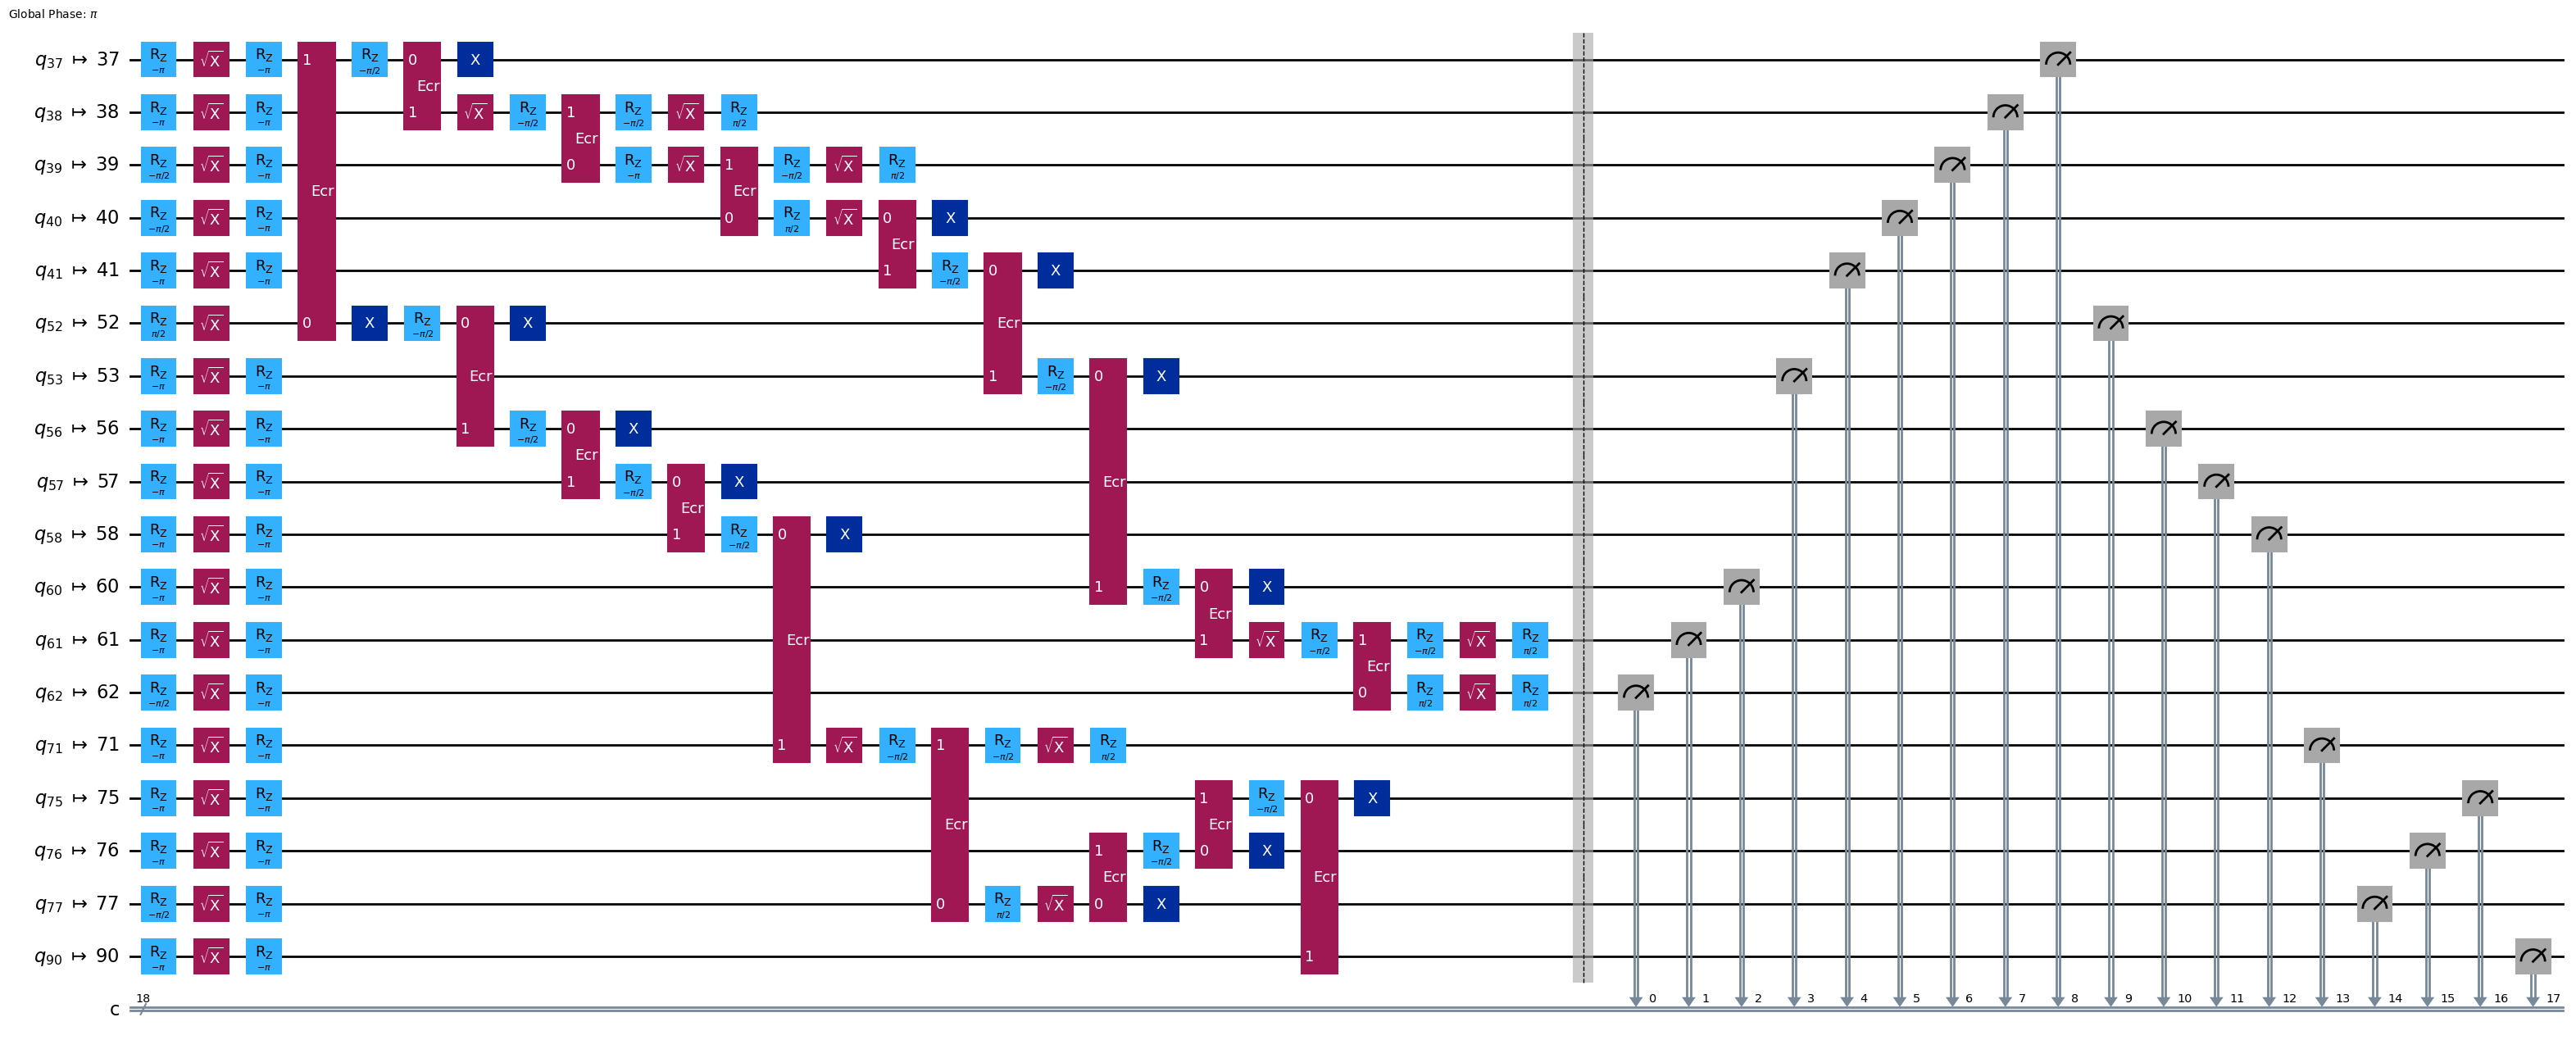

In [34]:
pm = generate_preset_pass_manager(1, backend=backend)
ghz1_transpiled = pm.run(ghz1)
ghz1_transpiled.draw(output="mpl", idle_wires=False, fold=-1)

In [35]:
print('Depth:', ghz1_transpiled.depth())
print('Two-qubit Depth:', ghz1_transpiled.depth(filter_function=lambda x: x.operation.num_qubits==2))

Depth: 28
Two-qubit Depth: 9


In [36]:
sampler = Sampler(mode=backend)
shots = 40000
job = sampler.run([ghz1_transpiled], shots = shots)
print("job id:", job.job_id())

job id: d3btegmdacis73dac1ug


In [37]:
job = service.job(job.job_id()) 
#job = service.job("d33q9n50qhlc73cqqg1g") 
job.status() # ジョブの実行状態を確認します

'DONE'

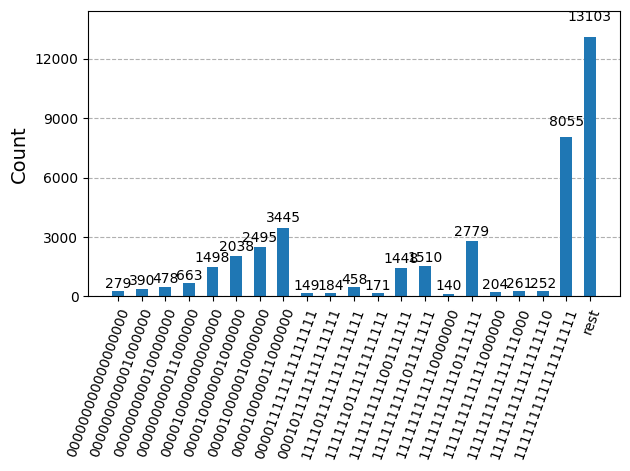

In [38]:
### 'DONE'になってから実行します ###
#from qiskit.visualization import plot_histogram
result = job.result()
plot_histogram(result[0].data.c.get_counts(), number_to_keep=20)

## 4. 幅優先探索でDepthを削減

次のアイデアは、量子ビットのバランスの取れたツリーを見つけることです。チェーンではなくツリーを使うことで、回路の深さはより浅くなるはずです。その前に、「悪い」読み出しエラーを持つノードと「悪い」ゲートエラーを持つエッジを結合グラフから削除します。

In [39]:
BAD_READOUT_ERROR_THRESHOLD = 0.1
BAD_ECRGATE_ERROR_THRESHOLD = 0.1
bad_readout_qubits = [q for q in range(backend.num_qubits) if backend.target["measure"][(q, )].error > BAD_READOUT_ERROR_THRESHOLD]
bad_ecrgate_edges = [qpair for qpair in backend.target[twoq_gate] if backend.target[twoq_gate][qpair].error > BAD_ECRGATE_ERROR_THRESHOLD]
print("Bad readout qubits:", bad_readout_qubits)
print("Bad twoq_gates:", bad_ecrgate_edges)

Bad readout qubits: [24, 68, 74, 106]
Bad twoq_gates: [(24, 34)]


In [40]:
g = backend.coupling_map.graph.copy().to_undirected()
g.remove_edges_from(bad_ecrgate_edges)  # remove edge first (otherwise may fail with a NoEdgeBetweenNodes error)
g.remove_nodes_from(bad_readout_qubits)

悪いエッジと悪い量子ビットを除いたカップリング・マップ・グラフを描いてみましょう。

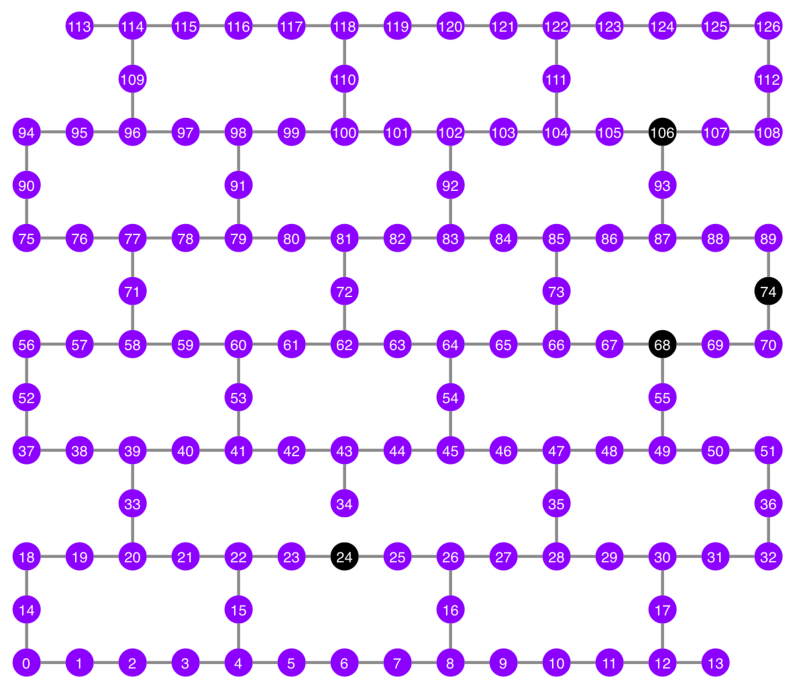

In [41]:
qubit_color = []
for i in range(backend.num_qubits):
    if i in bad_readout_qubits:
        qubit_color.append("#000000") #black
    else:
        qubit_color.append("#8c00ff") #purple
line_color = []
for e in backend.target.build_coupling_map().get_edges():
    if e in bad_ecrgate_edges:
        line_color.append("#ffffff") #white
    else:
        line_color.append("#888888") #gray
plot_gate_map(backend, qubit_color=qubit_color, line_color=line_color, qubit_size=45, font_size=20, figsize=(10, 10))

先ほどと同じように、18量子ビットでGHZ状態を作ってみます。

In [42]:
N = 18

ルートノードは、`betweenness_centrality` 関数を呼び出して見つけることができます。betweenness centralityの値が最も高いノードがグラフの中心にあるからです。参考：https://www.rustworkx.org/tutorial/betweenness_centrality.html 

あるいは手動でルートノードを選ぶこともできます。

In [43]:
#central = 65 #Select the center node manually
c_degree = dict(rx.betweenness_centrality(g))
central = max(c_degree, key=c_degree.get)
central

45

ルートノードから始めて、幅優先探索（BFS）により木を作ります。参考：https://qiskit.org/ecosystem/rustworkx/apiref/rustworkx.bfs_search.html#rustworkx-bfs-search


In [44]:
class TreeEdgesRecorder(rx.visit.BFSVisitor):
    def __init__(self, N):
        self.edges = []
        self.N = N

    def tree_edge(self, edge):
        self.edges.append(edge)
        if len(self.edges) >= self.N-1:
            raise rx.visit.StopSearch()

vis = TreeEdgesRecorder(N)
rx.bfs_search(g, [central], vis)
best_qubits = sorted(list(set(q for e in vis.edges for q in (e[0], e[1]))))
#print('Tree edges:', vis.edges)

In [45]:
print('Qubits selected:', best_qubits)

Qubits selected: [28, 34, 35, 41, 42, 43, 44, 45, 46, 47, 48, 49, 54, 62, 63, 64, 65, 66]


選択された量子ビットをカップリング・マップ・グラフにピンクでプロットしてみます。

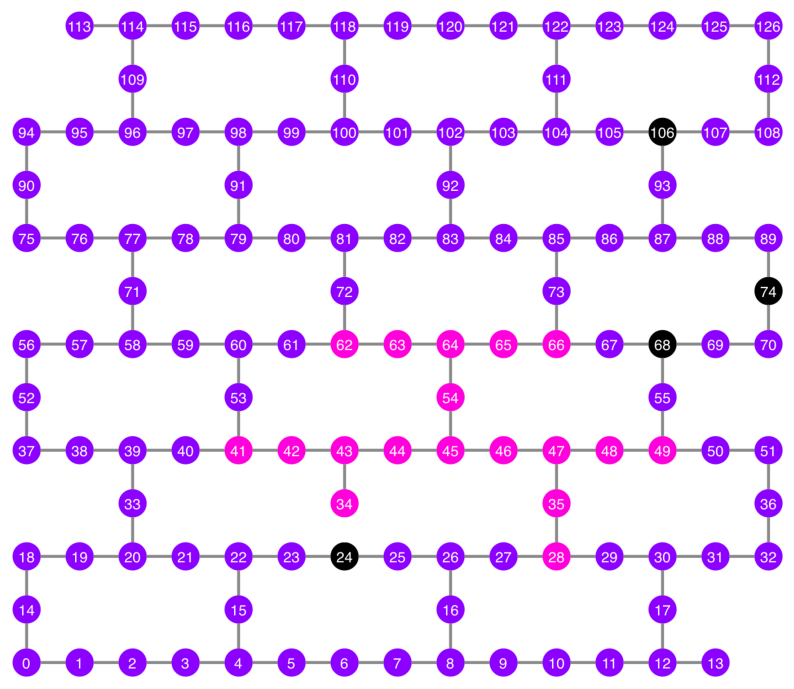

In [46]:
qubit_color = []
for i in range(backend.num_qubits):
    if i in bad_readout_qubits:
        qubit_color.append("#000000") #black
    elif i in best_qubits:
        qubit_color.append("#ff00dd") #pink
    else:
        qubit_color.append("#8c00ff") #purple
plot_gate_map(backend, qubit_color=qubit_color, line_color=line_color, qubit_size=45, font_size=20, figsize=(10, 10))

量子ビットのツリー構造を示してみましょう。

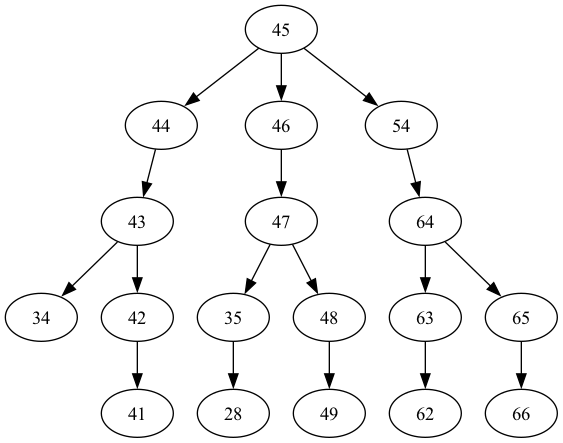

In [47]:
from rustworkx.visualization import graphviz_draw
tree = rx.PyDiGraph()
tree.extend_from_weighted_edge_list(vis.edges)
tree.remove_nodes_from([n for n in range(max(best_qubits)+1) if n not in best_qubits])

graphviz_draw(tree, method='dot')

ツリー構造に合わせてGHZ回路を構築します。

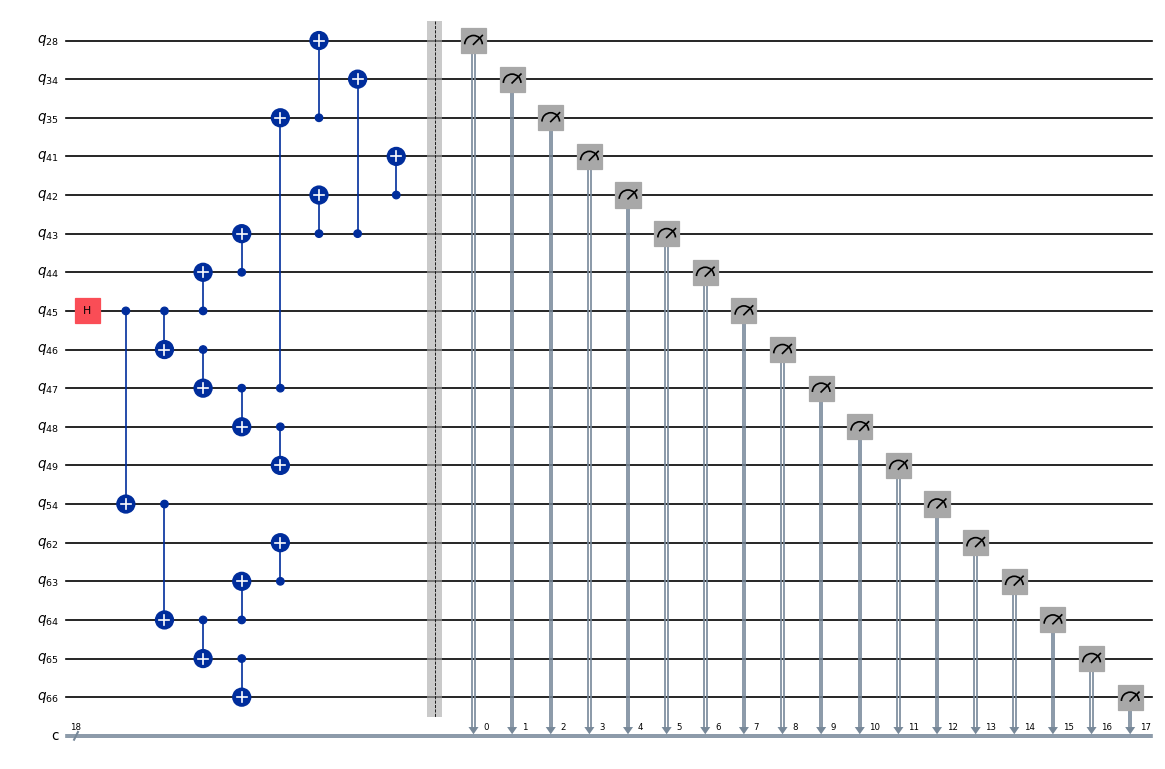

In [48]:
ghz2 = QuantumCircuit(max(best_qubits)+1, N)

ghz2.h(tree.edge_list()[0][0]) # apply H-gate to the root node
# Apply CNOT from the root node to the each edge.
for u, v in tree.edge_list():
    ghz2.cx(u, v)
ghz2.barrier()  # for visualization
ghz2.measure(best_qubits, list(range(N)))
ghz2.draw(output="mpl", idle_wires=False, fold=-1, scale=0.6)

In [49]:
ghz2.depth()

8

実機のバックエンドで実行します。

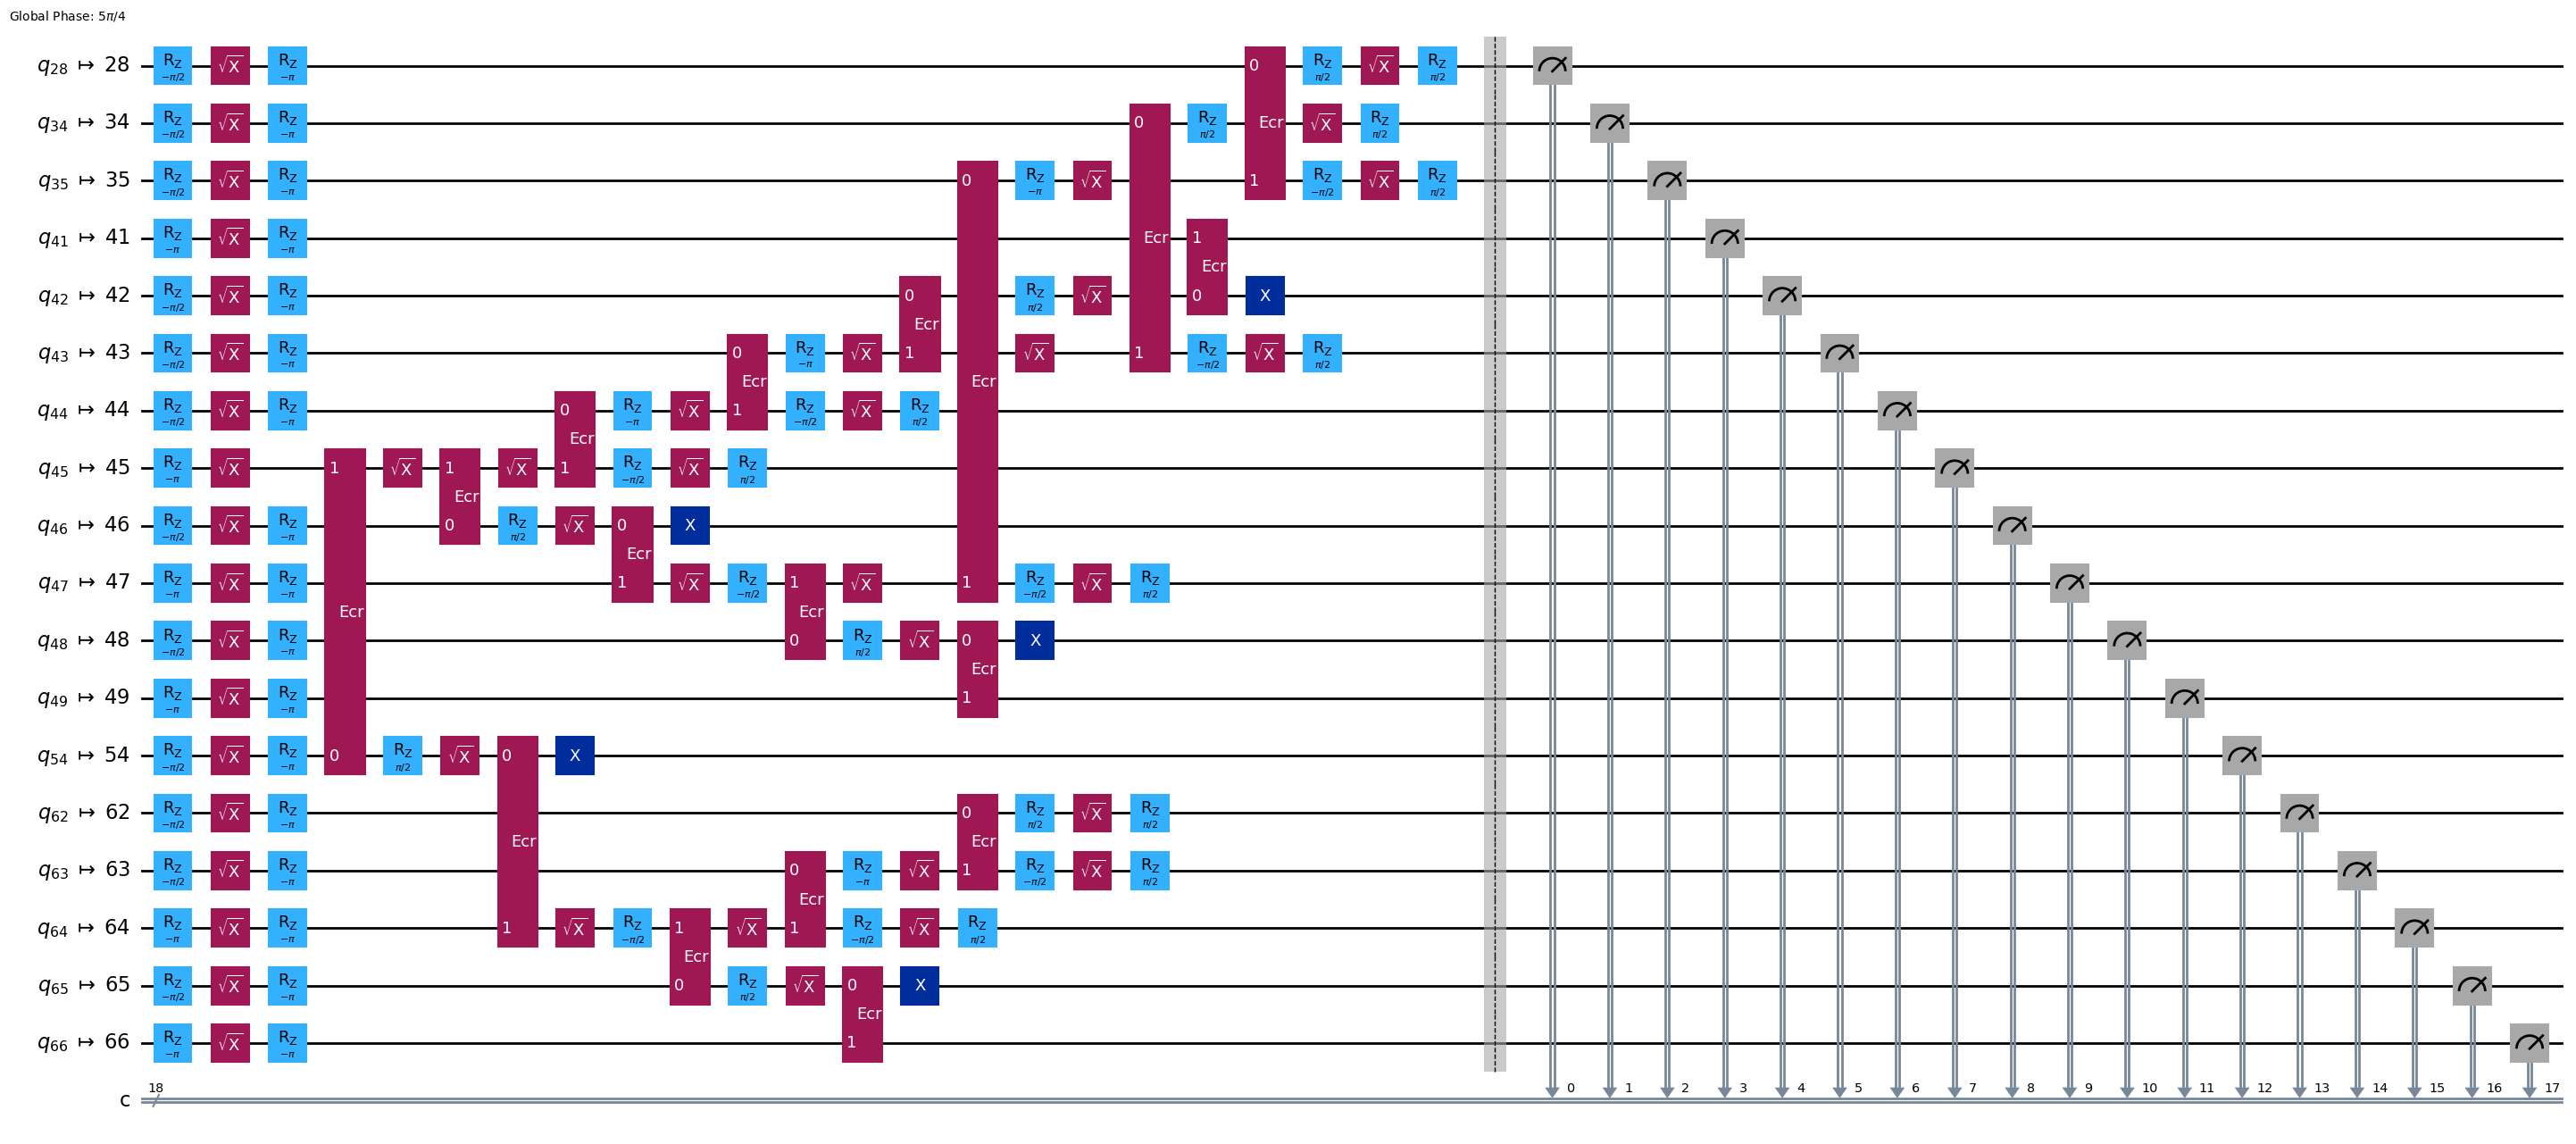

In [50]:
pm = generate_preset_pass_manager(1, backend=backend)
ghz2_transpiled = pm.run(ghz2)
ghz2_transpiled.draw(output="mpl", idle_wires=False, fold=-1)

In [51]:
print('Depth:', ghz2_transpiled.depth())
print('Two-qubit Depth:', ghz2_transpiled.depth(filter_function=lambda x: x.operation.num_qubits==2))

Depth: 21
Two-qubit Depth: 6


In [52]:
sampler = Sampler(mode=backend)
shots = 40000
job = sampler.run([ghz2_transpiled], shots = shots)
print("job id:", job.job_id())

job id: d3btfc7c8jls73bvmb80


In [53]:
job = service.job(job.job_id()) 
#job = service.job("d33q9n50qhlc73cqqg1g") 
job.status() # ジョブの実行状態を確認します

'DONE'

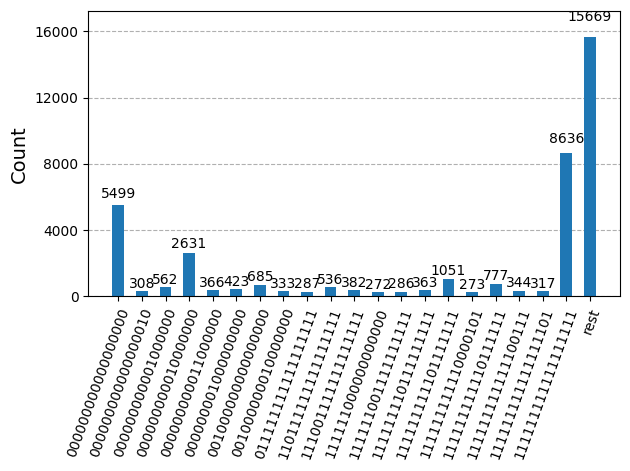

In [54]:
### 'DONE'になってから実行します ###
#from qiskit.visualization import plot_histogram
result = job.result()
plot_histogram(result[0].data.c.get_counts(), number_to_keep=20)

## 5. エラー緩和・抑制の手法の適用

エラー緩和・抑制オプションはサンプラーで設定できます。https://quantum.cloud.ibm.com/docs/en/guides/configure-error-mitigation および https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/dev/options-sampler-options を参照してください。

In [55]:
from qiskit_ibm_runtime import SamplerOptions

opts = SamplerOptions()
opts.twirling.enable_gates=False
opts.twirling.enable_measure = True
opts.dynamical_decoupling.skip_reset_qubits = True
opts.dynamical_decoupling.enable = True
opts.dynamical_decoupling.sequence_type = "XY4"

In [56]:
sampler = Sampler(mode=backend, options=opts)
shots = 40000
job = sampler.run([ghz2_transpiled], shots = shots)
print("job id:", job.job_id())

job id: d3btftvc8jls73bvmbo0


In [57]:
job = service.job(job.job_id()) 
#job = service.job("d33q9n50qhlc73cqqg1g") 
job.status() # ジョブの実行状態を確認します

'DONE'

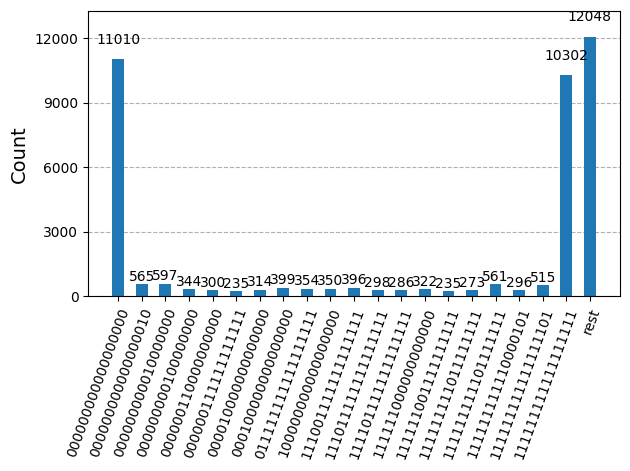

In [58]:
### 'DONE'になってから実行します ###
result = job.result()
plot_histogram(result[0].data.c.get_counts(), number_to_keep=20)

## 6. GHZフィデリティーの計算
では最後に、上記の回路を使ってGHZフィデリティーの計算をしてみましょう。この計算には2~3分時間がかかります。

In [59]:
from qiskit.providers import BackendV2
from qiskit_ibm_runtime import Estimator, Batch
from qiskit.quantum_info import SparsePauliOp

def execute_ghz_fidelity(
    ghz_circuit: QuantumCircuit,  # GHZ状態を生成する量子回路。古典レジスタ名は "c"
    physical_qubits: list[int],  # GHZ状態を表す物理量子ビット
    backend: BackendV2,
    sampler_options: dict | SamplerOptions | None = None,
):
    N_SHOTS = 40_000
    N = len(physical_qubits)
    base_circuit = ghz_circuit.remove_final_measurements(inplace=False)
    # M_k測定用回路
    mk_circuits = []
    for k in range(1, N + 1):
        circuit = base_circuit.copy()
        # 測定の基底を変換
        for q in physical_qubits:
            circuit.rz(-k * np.pi / N, q)
            circuit.h(q)
        mk_circuits.append(circuit)

    obs = SparsePauliOp.from_sparse_list(
        [("Z" * N, physical_qubits, 1)], num_qubits=backend.num_qubits
    )
    job_ids = []
    pm1 = generate_preset_pass_manager(1, backend=backend)
    org_transpiled = pm1.run(ghz_circuit)
    mk_transpiled = pm1.run(mk_circuits)
    with Batch(backend=backend):
        sampler = Sampler(options=sampler_options)
        sampler.options.twirling.enable_measure = True
        job = sampler.run([org_transpiled], shots=N_SHOTS)
        job_ids.append(job.job_id())
        print(f"Sampler job id: {job.job_id()}, shots={N_SHOTS}")
        estimator = Estimator()  # TREX is applied as default
        estimator.options.dynamical_decoupling.enable = True
        estimator.options.execution.rep_delay = 0.0005
        estimator.options.twirling.enable_measure = True
        job2 = estimator.run([(circ, obs) for circ in mk_transpiled], precision=1 / 100)
        job_ids.append(job2.job_id())
        print("Estimator job id:", job2.job_id())

In [60]:
def check_ghz_fidelity_from_jobs(
    sampler_job,
    estimator_job,
    num_qubits,
    shots = 40_000,
):
    N = num_qubits
    sampler_result = sampler_job.result()
    counts = sampler_result[0].data.c.get_counts()
    all_zero = counts.get("0" * N, 0) / shots
    all_one = counts.get("1" * N, 0) / shots
    top3 = sorted(counts, key=counts.get, reverse=True)[:3]
    print(f"N={N}: |00..0>: {counts.get('0'*N, 0)}, |11..1>: {counts.get('1'*N, 0)}, |3rd>: {counts.get(top3[2], 0)} ({top3[2]})")
    print(f"P(|00..0>)={all_zero}, P(|11..1>)={all_one}")

    estimator_result = estimator_job.result()
    non_diagonal = (1 / N) * sum(
        (-1) ** k * estimator_result[k - 1].data.evs for k in range(1, N + 1)
    )
    print(f"REM: Coherence (non-diagonal): {non_diagonal:.6f}")
    fidelity = 0.5 * (all_zero + all_one + non_diagonal)
    sigma = 0.5 * np.sqrt(
        (1 - all_zero - all_one) * (all_zero + all_one) / shots
        + sum(estimator_result[k].data.stds ** 2 for k in range(N)) / (N * N)
    )
    print(f"GHZ fidelity = {fidelity:.6f} ± {sigma:.6f}")
    if fidelity - 2 * sigma > 0.5:
        print("GME (genuinely multipartite entangled) test: Passed")
    else:
        print("GME (genuinely multipartite entangled) test: Failed")
    return {
        "fidelity": fidelity,
        "sigma": sigma,
        "shots": shots,
        "job_ids": [sampler_job.job_id(), estimator_job.job_id()],
    }

In [61]:
res = execute_ghz_fidelity(
    ghz_circuit=ghz2,
    physical_qubits=best_qubits,
    backend=backend,
    sampler_options=opts,
)

Sampler job id: d3btgoedacis73dac40g, shots=40000
Estimator job id: d3btgonc8jls73bvmchg


In [62]:
# ジョブの実行状態を確認します
job_s = service.job('d3btgoedacis73dac40g') # 例です。上に出力された自分のjob_idを入れて実行してください。 
job_e = service.job('d3btgonc8jls73bvmchg')
print(job_s.status(), job_e.status())

DONE DONE


In [63]:
### 'DONE'になってから実行します ###
N = 18
# Check fidelity from job IDs
res = check_ghz_fidelity_from_jobs(
    sampler_job=job_s,
    estimator_job=job_e,
    num_qubits=N,
)

N=18: |00..0>: 11288, |11..1>: 10300, |3rd>: 654 (000000000010000000)
P(|00..0>)=0.2822, P(|11..1>)=0.2575
REM: Coherence (non-diagonal): 0.555317
GHZ fidelity = 0.547508 ± 0.002694
GME (genuinely multipartite entangled) test: Passed


GHZフィデリティーが0.5以上だとPassedと表示されます。

ここまで3つのアイデアを見てきました。これらのアイデアを組み合わせて拡張することもできますし、より良いGHZ回路を作るために独自のアイデアを思いつくこともできます。

## 演習
アイディアを組み合わせて、GHZフィデリティーが0.5以上のGHZ状態をできるだけ大きな量子ビットで作ってください。    
オープンユーザーのバックエンド実行時間は1ヶ月あたり10分までなので、何度もGHZフィデリティーを測らないようにしましょう。